# Plotting FFT data
### This notebook contains the following:

    1. One function (load_interval) for loading FFT WT data for a given component
    2. One function (plot_2d_bins) for plotting the RMS bin values in 2D
    3. Two function (print3d_with_poly_collection & print3d_with_axes3d) for plotting frequency (x), amplitide (z) and interval (y) in 3D. Only the first one is used.
    4. One function for plotting RMS values across bins to mean RPM of the shaft.

In [12]:
!which python
import sys
sys.executable

/usr/local/bin/python


'/Users/stianismar/Dropbox/gitProsjekter/master-thesis/venv/bin/python'

In [14]:
import numpy as np
from matplotlib.collections import PolyCollection
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.pyplot as plt
import random
import sys, os

ROOT_PATH = os.path.abspath("..").split("data_processing")[0]
print("ROOT", ROOT_PATH)
module_path = os.path.abspath(os.path.join(ROOT_PATH+"/utils/"))
if module_path not in sys.path:
    print("appended")
    sys.path.append(module_path)

import functions as f

module_path = os.path.abspath(os.path.join(ROOT_PATH+"/data_processing/"))
if module_path not in sys.path:
    print("appended")
    sys.path.append(module_path)
    
import wt_data

import ff_transform


ROOT /Users/stianismar/Dropbox/gitProsjekter/master-thesis/src


 ## __load_interval__ loads all the intervals for one turbine (GEARBOX)
This feature has the name 'GbxHssRr;0,0102;m/s2'.

In [15]:
'''
wt_name is either 'WTG01', 'WTG02', 'WTG03', or 'WTG04'

'''
def load_interval(wt_name, BINS,SENSOR_NAME, load_minimal=False):
    wt_instance = wt_data.load_instance(wt_name, load_minimal=False)
    print(f"This is the amount of intervals: {len(wt_instance.ten_second_intervals)}")
    
    y = []
    x = []
    z = []
    
    avg_powers = [] # Stores the average power for each interval
    
    
    two_d_plot = d = [[] for x in range(BINS)]
    
    avg_rot_speeds = []
    
    i = 0
    for interval in wt_instance.ten_second_intervals:
        ts = interval.sensor_df['TimeStamp']  # Have this as the y-axis to see how the RMS/frequencies develop
        try:
            vibration_signal = interval.sensor_df[SENSOR_NAME]
        except:
            continue


        y_repeated = np.repeat(i, 50)  # Repeat this y value n times to use as the y value for the corresponding x (frequency) and z (magnitude)
        y.append(y_repeated)
        i = i + 1

        comp_type = 'gearbox'
        
        rot_data = interval.high_speed_rot_data
        avg_rot_speed = rot_data['mean']
        avg_rot_speeds.append(avg_rot_speed)
        
        
        
        avg_power = interval.op_df["PwrAvg;kW"][0]
        rot_data = interval.high_speed_rot_data
        
        fast = ff_transform.FastFourierTransform( vibration_signal, ts, comp_type)
        fft, time, centroid, rms, rms_bins, bin_freq = fast.fft_transform_time(rot_data,
                                                                               avg_power,
                                                                               calc_rms_for_bins=True,
                                                                     plot=False,
                                                                     bins=BINS,
                                                                     plot_vertical_lines=False)
        N = fast.s.size
        T = fast.t[1] - fast.t[0]
        f = np.linspace(0, 1 / T, N, )
        f = f[:N // 2]

        z.append(rms_bins)
        x.append(bin_freq)
        avg_powers.append(interval.op_df['PwrAvg;kW'][0])
        
        for j, rms_amplitude in enumerate(rms_bins):
            two_d_plot[j].append(rms_amplitude)
        
        

        
    x = np.array(x)
    y = np.array(y)
    z = np.array(z)
    return x,y,z, two_d_plot, avg_powers, avg_rot_speeds

## 2D plotting function

In [16]:
# Plotting 2d bins
def plot_2d_bins(bin_values):
    num_intervals = len(bin_values[0])
    #fig = plt.figure()
    
    # fig, axs = plt.subplots(10,5, figsize=(15,20), facecolor='w', edgecolor='k',dpi=200)    

    # fig.subplots_adjust(hspace = .5, wspace=.001)
    # plt.subplots_adjust(top=0.96)

    # axs = axs.ravel()
    
    x_news = []
    y_news = []
    #plt.suptitle('RMS development for each interval')
    for j, binn in enumerate(bin_values):
        
        # Fitting a polynomial to each bin plot: 
        # get x and y vectors
        y = binn
        x = np.arange(0,len(binn))
        
        # calculate polynomial
        z = np.polyfit(x, y, 3)
        f = np.poly1d(z)
        plt.plot(x,y)
        # calculate new x's and y's
        x_new = np.linspace(x[0], x[-1], 50)
        y_new = f(x_new)
        
        # axs[j].plot(binn) # Plotting the RMS
        # axs[j].plot(x_new, y_new,color='orange') # Plotting the fitted line on top of that
        # axs[j].autoscale(enable=True, axis='y', tight=None)
        # axs[j].set_title(f"Bin {j+1}. Freq. range:")
        # axs[j].margins(0)
        x_news.append(x_new)
        y_news.append(y_new)
    
    # fig.tight_layout() 
    # plt.show()

    
    fig = plt.figure(figsize = (15,10))
    # plt.style.use('seaborn')    
    for i,x in enumerate(x_news):
        plt.plot(x,y_news[i], label=1)
        x_post = i %  50
        plt.ylim(top = np.max(y_news) + 0.2)

        # plt.text(x[x_post], y_news[i][1], 'sample {i}'.format(i=i), fontsize = 8)

    # plt.legend(fontsize=8)
    # plt.legend(np.arange(1,51),fontsize = 8)
    # labelLines(plt.gca().get_lines(),align=True,fontsize=14)

    plt.margins(0)
    fig.tight_layout() 

    plt.show()

## Creating a 3d plot using PolyCollection (X: Frequency, Y: Interval number, Z: RMS)

In [17]:
'''
    Create a 3d-plot using the poly collection module from matplotlib.
'''
from matplotlib import cm, pyplot as plt
import math
def print3d_with_poly_collection1(t,x,y,z,color_alt,average_powers, cm_style='Blues',filter = False):

    if filter == True:
        z = filter_RMS_spikes(x,y,z)
    
    fig = plt.figure(figsize=(15,6))
    ax = fig.add_subplot(111, projection='3d')
    ax.set_title(f"FFT development over time for WT {t}", pad=20)

    
    # Get the numpy arrays on the correct shape
    freq_data = x.T
    amp_data = z.T
    rad_data = np.linspace(0,amp_data.shape[1],amp_data.shape[1])
    
    verts = []

    for irad in range(len(rad_data)):
        # I'm adding a zero amplitude at the beginning and the end to get a nice
        # flat bottom on the polygons
        xs = np.concatenate([[freq_data[0,irad]], freq_data[:,irad], [freq_data[-1,irad]]])
        ys = np.concatenate([[0],amp_data[:,irad],[0]])
        verts.append(list(zip(xs, ys)))

    # Colors:
    
    if color_alt == 'color_alt4':
        cmap = cm.get_cmap(cm_style)
        # inferno
        
        #norm = [float(i)/sum(average_powers) for i in average_powers]
        #col = [cmap(x) for x in norm]
        # print(np.random.rand(amp_data.shape[1]))
        col = [cmap(x) for x in np.random.rand(amp_data.shape[1])]
        print("col.shape", col.shape)
        poly = PolyCollection(verts, facecolors = col)

    else:
        
        poly = PolyCollection(verts)


    # facecolors = col
    # facecolors = ['r', 'g', 'c', 'y','r', 'g', 'c', 'y','r', 'g', 'c']
    poly.set_alpha(0.7)
    # poly.set_cmap('blues')

    # The zdir keyword makes it plot the "z" vertex dimension (radius)
    # along the y axis. The zs keyword sets each polygon at the
    # correct radius value.
    ax.add_collection3d(poly, zs=rad_data, zdir='y')

    ax.set_xlim3d(freq_data.min(), freq_data.max())
    
    ax.set_xlabel('Frequency [Hz]',labelpad=10)
    ax.set_ylim3d(rad_data.min(), rad_data.max())
    ax.set_ylabel('Interval number',labelpad=10)
    # ax.set_zlim3d(amp_data.min(), amp_data.max())
    ax.set_zlim3d(amp_data.min(), 8)
    ax.set_zlabel('RMS amplitude')

    # Colourbar
    print(max(average_powers)) # 3314.455810547
    sm = plt.cm.ScalarMappable(cmap=cmap)
    sm.set_array([])
    mn=int(np.floor(0))  
    mx=int(np.ceil(max(average_powers)))
    md=(mx-mn)/2
    cb = plt.colorbar(sm)
    cb.set_ticks([0, 0.5, 1])
    cb.set_ticklabels([mn,md,mx],update_ticks=True)
    
    cb.set_label('Magnitude of Average Power for turbine')

    # fig.clim(vmin = 0,vmax = [0, max_val])

    plt.xticks(fontsize=10)
    plt.yticks(fontsize=10)
    ax.tick_params(axis='both', which='major', pad=1)
    # plt.zticks(fontsize=10)
    
    
    cmap="Blues"
    norm = matplotlib.colors.Normalize(vmin=min(average_rpm_filtered_wt01),vmax=max(average_rpm_filtered_wt01))
    scat = ax.scatter(xs, ys, zs,c=c,cmap=cmap,norm=norm)
    scat.update_scalarmappable()
    scat.set_facecolors('k')
    scat.set_cmap(cmap)
    scat.set_norm(norm)
    plt.show()

In [23]:
import matplotlib
import matplotlib.cm as cmx
from sklearn.preprocessing import minmax_scale
'''
    Create a 3d-plot using the poly collection module from matplotlib.
'''
from matplotlib import cm, pyplot as plt
import math
def print3d_with_poly_collection(t,remove_indexes_01,x,y,z,color_alt,average_powers, cm_style='Blues',filter = False):
    # y = np.arange(0,len(average_powers))    
    #print(y)
    #print(len(average_powers))
    #print("remove_indexes_01: ", remove_indexes_wt01)
    
    # print("y.shape", y[400])
    
    # Delete from the avg_powers and average_rot_speed array
    for i, index in enumerate(remove_indexes_01):
        y = np.delete(y, [index], axis=0)
        x = np.delete(x, [index], axis=0)
        z = np.delete(z, [index], axis=0)
            
    print("len(x): ", len(x))
    print("len(y): ", len(y))
    print("len(z): ", len(z))

    print(len(average_powers))
    if filter == True:
        z = filter_RMS_spikes(x,y,z)
    
    fig = plt.figure(figsize=(15,6))
    ax = fig.add_subplot(111, projection='3d')
    ax.set_title(f"FFT development over time for WT {t}",pad=20)
    
    # Get the numpy arrays on the correct shape
    freq_data = x.T
    amp_data = z.T
    rad_data = np.linspace(0,amp_data.shape[1],amp_data.shape[1])
    
    verts = []

    for irad in range(len(rad_data)):
        # I'm adding a zero amplitude at the beginning and the end to get a nice
        # flat bottom on the polygons
        xs = np.concatenate([[freq_data[0,irad]], freq_data[:,irad], [freq_data[-1,irad]]])
        ys = np.concatenate([[0],amp_data[:,irad],[0]])
        verts.append(list(zip(xs, ys)))

    # Colors:
    
    if color_alt == 'color_alt4':
        cmap="Blues"
        cmap = cmx.get_cmap(cmap)
        scaled = minmax_scale(average_powers)
        #print(f"MIN: {min(norm)}. MAX: {max(norm)}")
        col = [cmap(x) for x in scaled]
        # print(col)
        poly = PolyCollection(verts,facecolors=col)
        # poly.set_cmap(cmap)
        # poly.set_norm(norm)
        # poly.update_scalarmappable()
        # poly.set_facecolors('k')
        # poly.set_cmap(cmap)
        # poly.set_norm(norm)
    else:
        poly = PolyCollection(verts)
    poly.set_alpha(0.7)

    # The zdir keyword makes it plot the "z" vertex dimension (radius)
    # along the y axis. The zs keyword sets each polygon at the
    # correct radius value.
    ax.add_collection3d(poly, zs=rad_data, zdir='y')
    ax.set_xlim3d(freq_data.min(), freq_data.max())
    ax.set_xlabel('Frequency [Hz]',labelpad=10)
    ax.set_ylim3d(rad_data.min(), rad_data.max())
    ax.set_ylabel('Interval number',labelpad=10)
    # ax.set_zlim3d(amp_data.min(), amp_data.max())
    ax.set_zlim3d(amp_data.min(), 8)
    ax.set_zlabel('RMS amplitude')

    # Colourbar
    print(max(average_powers)) # 3314.455810547
    sm = plt.cm.ScalarMappable(cmap=cmap)
    sm.set_array([])
    mn=int(np.floor(min(average_powers)))  
    mx=int(np.ceil(max(average_powers)))
    md=(mx-mn)/2
    cb = plt.colorbar(sm)
    cb.set_ticks([0, 0.5, 1])
    cb.set_ticklabels([mn,md,mx],update_ticks=True)
    cb.set_label('Magnitude of Average Power for turbine')
    plt.xticks(fontsize=10)
    plt.yticks(fontsize=10)
    ax.tick_params(axis='both', which='major', pad=1)
    # plt.zticks(fontsize=10)
    plt.show()
    
'''print3d_with_poly_collection("1",remove_indexes_wt01,
                             freqs_wt01,
                             interval_nums_wt01, 
                             rms_amplitudes_wt01,
                             'color_alt4',
                             avg_powers_filtered_wt01,
                             'Blues',
                             False)
                             
'''

'print3d_with_poly_collection("1",remove_indexes_wt01,\n                             freqs_wt01,\n                             interval_nums_wt01, \n                             rms_amplitudes_wt01,\n                             \'color_alt4\',\n                             avg_powers_filtered_wt01,\n                             \'Blues\',\n                             False)\n                             \n'

In [24]:
### Remove spikes that seem unnaturally large (by inspection). From the 3D plots,
### one can see that the spikes show up "randomly". They are therefore filtered away
def filter_RMS_spikes(x,y,z):
    for i, array in enumerate(z):
        for j, rms_val in enumerate(array):
            if rms_val > 10:
                # divide it by 2
                z[i][j] = rms_val/2
                print(f"Previous value: {rms_val}. New value: {z[i][j]}")
                
    return z

## Creating surface 3d plots with axes3d

In [25]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import cm

def print3d_with_axes3d(x,y,z,cm_style='Blues'):
    X = np.array(x)
    Y = np.array(y)
    Z = np.array(z)
    
    X = X.T
    Y = Y.T
    Z = Z.T
    
    fig = plt.figure()
    ax = fig.gca(projection='3d')
    cmap = cm.get_cmap(cm_style)
    surf = ax.plot_surface(X, Y, Z, cmap=cmap,
                           linewidth=0, antialiased=False)
    plt.title("Frequency development over intervals for WT")
    plt.show()

## Running the functions
Loading up the WT's

**WTG01**

In [26]:
WIND_TURBINE = 'WTG01'
SENSOR_NAME = 'GbxHssRr;0,0102;m/s2'
BINS = 50

freqs_wt01, interval_nums_wt01, rms_amplitudes_wt01,two_d_plot_tw01, avg_powers_wt01, avg_rot_speeds1 = load_interval(WIND_TURBINE,
                                                                    BINS,
                                                     SENSOR_NAME,
                                                     load_minimal=False)
print(freqs_wt01.shape)
print(rms_amplitudes_wt01.shape)
print(interval_nums_wt01.shape)


Loading WTG01...
Loaded WTG01
This is the amount of intervals: 415
(414, 50)
(414, 50)
(414, 50)


**WTG02**

In [27]:
WIND_TURBINE = 'WTG02'
SENSOR_NAME = 'GbxHssRr;0,0102;m/s2'
BINS = 50

freqs_wt02, interval_nums_wt02, rms_amplitudes_wt02,two_d_plot_tw02,avg_powers_wt02, avg_rot_speeds2 = load_interval(WIND_TURBINE,
                                                                    BINS,
                                                     SENSOR_NAME,
                                                     load_minimal=False)

print(freqs_wt02.shape)
print(rms_amplitudes_wt02.shape)
print(interval_nums_wt02.shape)



Loading WTG02...
Loaded WTG02
This is the amount of intervals: 426
(426, 50)
(426, 50)
(426, 50)


**WTG03**

In [28]:
WIND_TURBINE = 'WTG03'
SENSOR_NAME = 'GbxHssRr;0,0102;m/s2'
BINS = 50

freqs_wt03, interval_nums_wt03, rms_amplitudes_wt03,two_d_plot_tw03,avg_powers_wt03, avg_rot_speeds3 = load_interval(WIND_TURBINE,
                                                                    BINS,
                                                     SENSOR_NAME,
                                                     load_minimal=False)
print(freqs_wt03.shape)
print(rms_amplitudes_wt03.shape)
print(interval_nums_wt03.shape)



Loading WTG03...
Loaded WTG03
This is the amount of intervals: 418
(418, 50)
(418, 50)
(418, 50)


**WTG04**

In [29]:
WIND_TURBINE = 'WTG04'
SENSOR_NAME = 'GbxHssRr;0,0102;m/s2'
BINS = 50

freqs_wt04, interval_nums_wt04, rms_amplitudes_wt04,two_d_plot_tw04,avg_powers_wt04, avg_rot_speeds4 = load_interval(WIND_TURBINE,
                                                                    BINS,
                                                     SENSOR_NAME,
                                                     load_minimal=False)
print(freqs_wt04.shape)
print(rms_amplitudes_wt04.shape)
print(interval_nums_wt04.shape)



Loading WTG04...
Loaded WTG04
This is the amount of intervals: 431
(431, 50)
(431, 50)
(431, 50)


## Filtering away the noise (some of the avg. power values were at -1*10^37)

In [30]:
'''
    Takes in the amount of bins to be plotted (bin_amount),
    the average powers list for each interval, and
    the bin_rms_values
'''
def scatter_plot_rms_avg_power(bin_list, avg_powers, bin_rms_values,wt_num):
    try:
        wt_num = wt_num.split('0')[1]
        
    except:
        print("wt_num is not the wrong format")
    
    rows = int(np.floor(len(bin_list)/3))
    check = len(bin_list) % 3
    if check > 0:
        rows += 1
        
    fig = plt.figure()    
    
    for bin_num in (bin_list):
        if len(bin_rms_values[bin_num]) == len(avg_powers):
            ax = fig.add_subplot(1,1,1)
            ax.scatter(avg_powers,bin_rms_values[bin_num])
        else:
            print(f"The shape is not the same. {len(bin_rms_values[bin_num])} =! {len(avg_powers)}'")
            
    
    len(bin_list)
    legend_labels = ['Bin ' + str(elem) for i, elem in enumerate(bin_list)]
    ax.legend(labels=legend_labels, loc='upper left',
             markerscale=3.,fontsize=10)
    plt.xlabel("Average power [kW]")
    plt.margins(0)
    print((max(avg_powers)))
    plt.xticks(np.arange(0, int(math.ceil(max(avg_powers) / 100.0)) * 100, 200))

    plt.ylabel("RMS")
    plt.title(f"RMS and Average Power for WT {wt_num}" "\n" f"Frequency range: [{bin_list[0]*256},{bin_list[-1]*256}] Hz")
    
    
def filter_data(avg_powers, RMS_per_bin, average_rpm): # filter the data based on the really avg low power values
    
    print("Old min power value: ", np.min(avg_powers))

    avg_powers_filtered = avg_powers
    RMS_per_bin_filtered = RMS_per_bin
    average_rpm_filtered = average_rpm

    indexes = []

    # Find out where these extreme values lie in the average powers array
    for i, val in enumerate(avg_powers_filtered):
        if val <= 0:
            indexes.append(i)
    indexes.reverse() # reverse list in order to delete the low powers
    
    if (len(indexes) == 0):
        print("Already ran.. ")
    else:
        # Delete from the avg_powers and average_rot_speed array
        for i, index in enumerate(indexes):
            del avg_powers_filtered[index]
            del average_rpm_filtered[index]

        # Delete from the RMS bin lists
        for index in indexes:
            for i, rms_bin in enumerate(RMS_per_bin_filtered):
                del rms_bin[index]

        print("New min power value", np.min(avg_powers_filtered))
        remove_indexes = indexes
        return avg_powers_filtered, RMS_per_bin_filtered, average_rpm_filtered, remove_indexes

In [31]:
# WT_01
avg_powers_filtered_wt01, RMS_per_bin_filtered_wt01, average_rpm_filtered_wt01,remove_indexes_wt01 = filter_data(
    avg_powers_wt01,
    two_d_plot_tw01,
    avg_rot_speeds1
)

# WT_02
avg_powers_filtered_wt02, RMS_per_bin_filtered_wt02, average_rpm_filtered_wt02,remove_indexes_wt02 = filter_data(
    avg_powers_wt02,
    two_d_plot_tw02,
    avg_rot_speeds2
)

# WT_03
avg_powers_filtered_wt03, RMS_per_bin_filtered_wt03, average_rpm_filtered_wt03,remove_indexes_wt03 = filter_data(
    avg_powers_wt03,
    two_d_plot_tw03,
    avg_rot_speeds3
)

# WT_03
avg_powers_filtered_wt04, RMS_per_bin_filtered_wt04, average_rpm_filtered_wt04, remove_indexes_wt04 = filter_data(
    avg_powers_wt04,
    two_d_plot_tw04,
    avg_rot_speeds4
)

Old min power value:  -1e+37
New min power value 388.6750183105
Old min power value:  -1e+37
New min power value 379.3480529785
Old min power value:  -1e+37
New min power value 373.8760070801
Old min power value:  -1e+37
New min power value 400.6371154785


# Plotting 2D: Studying the development of the bins

plot_2d_bins(two_d_plot_ tw01)


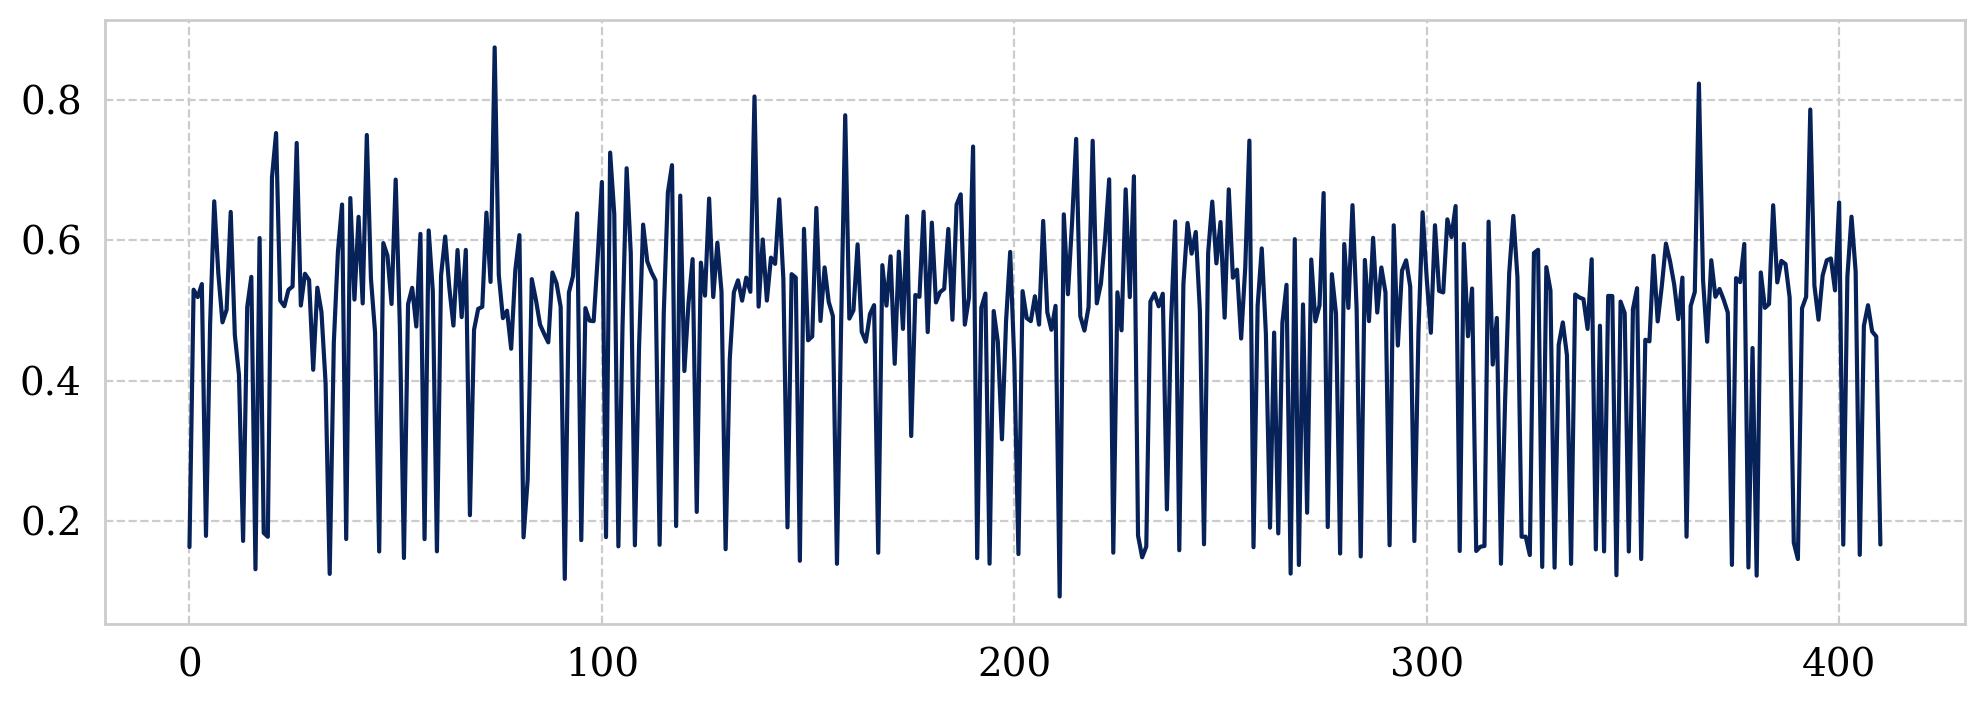

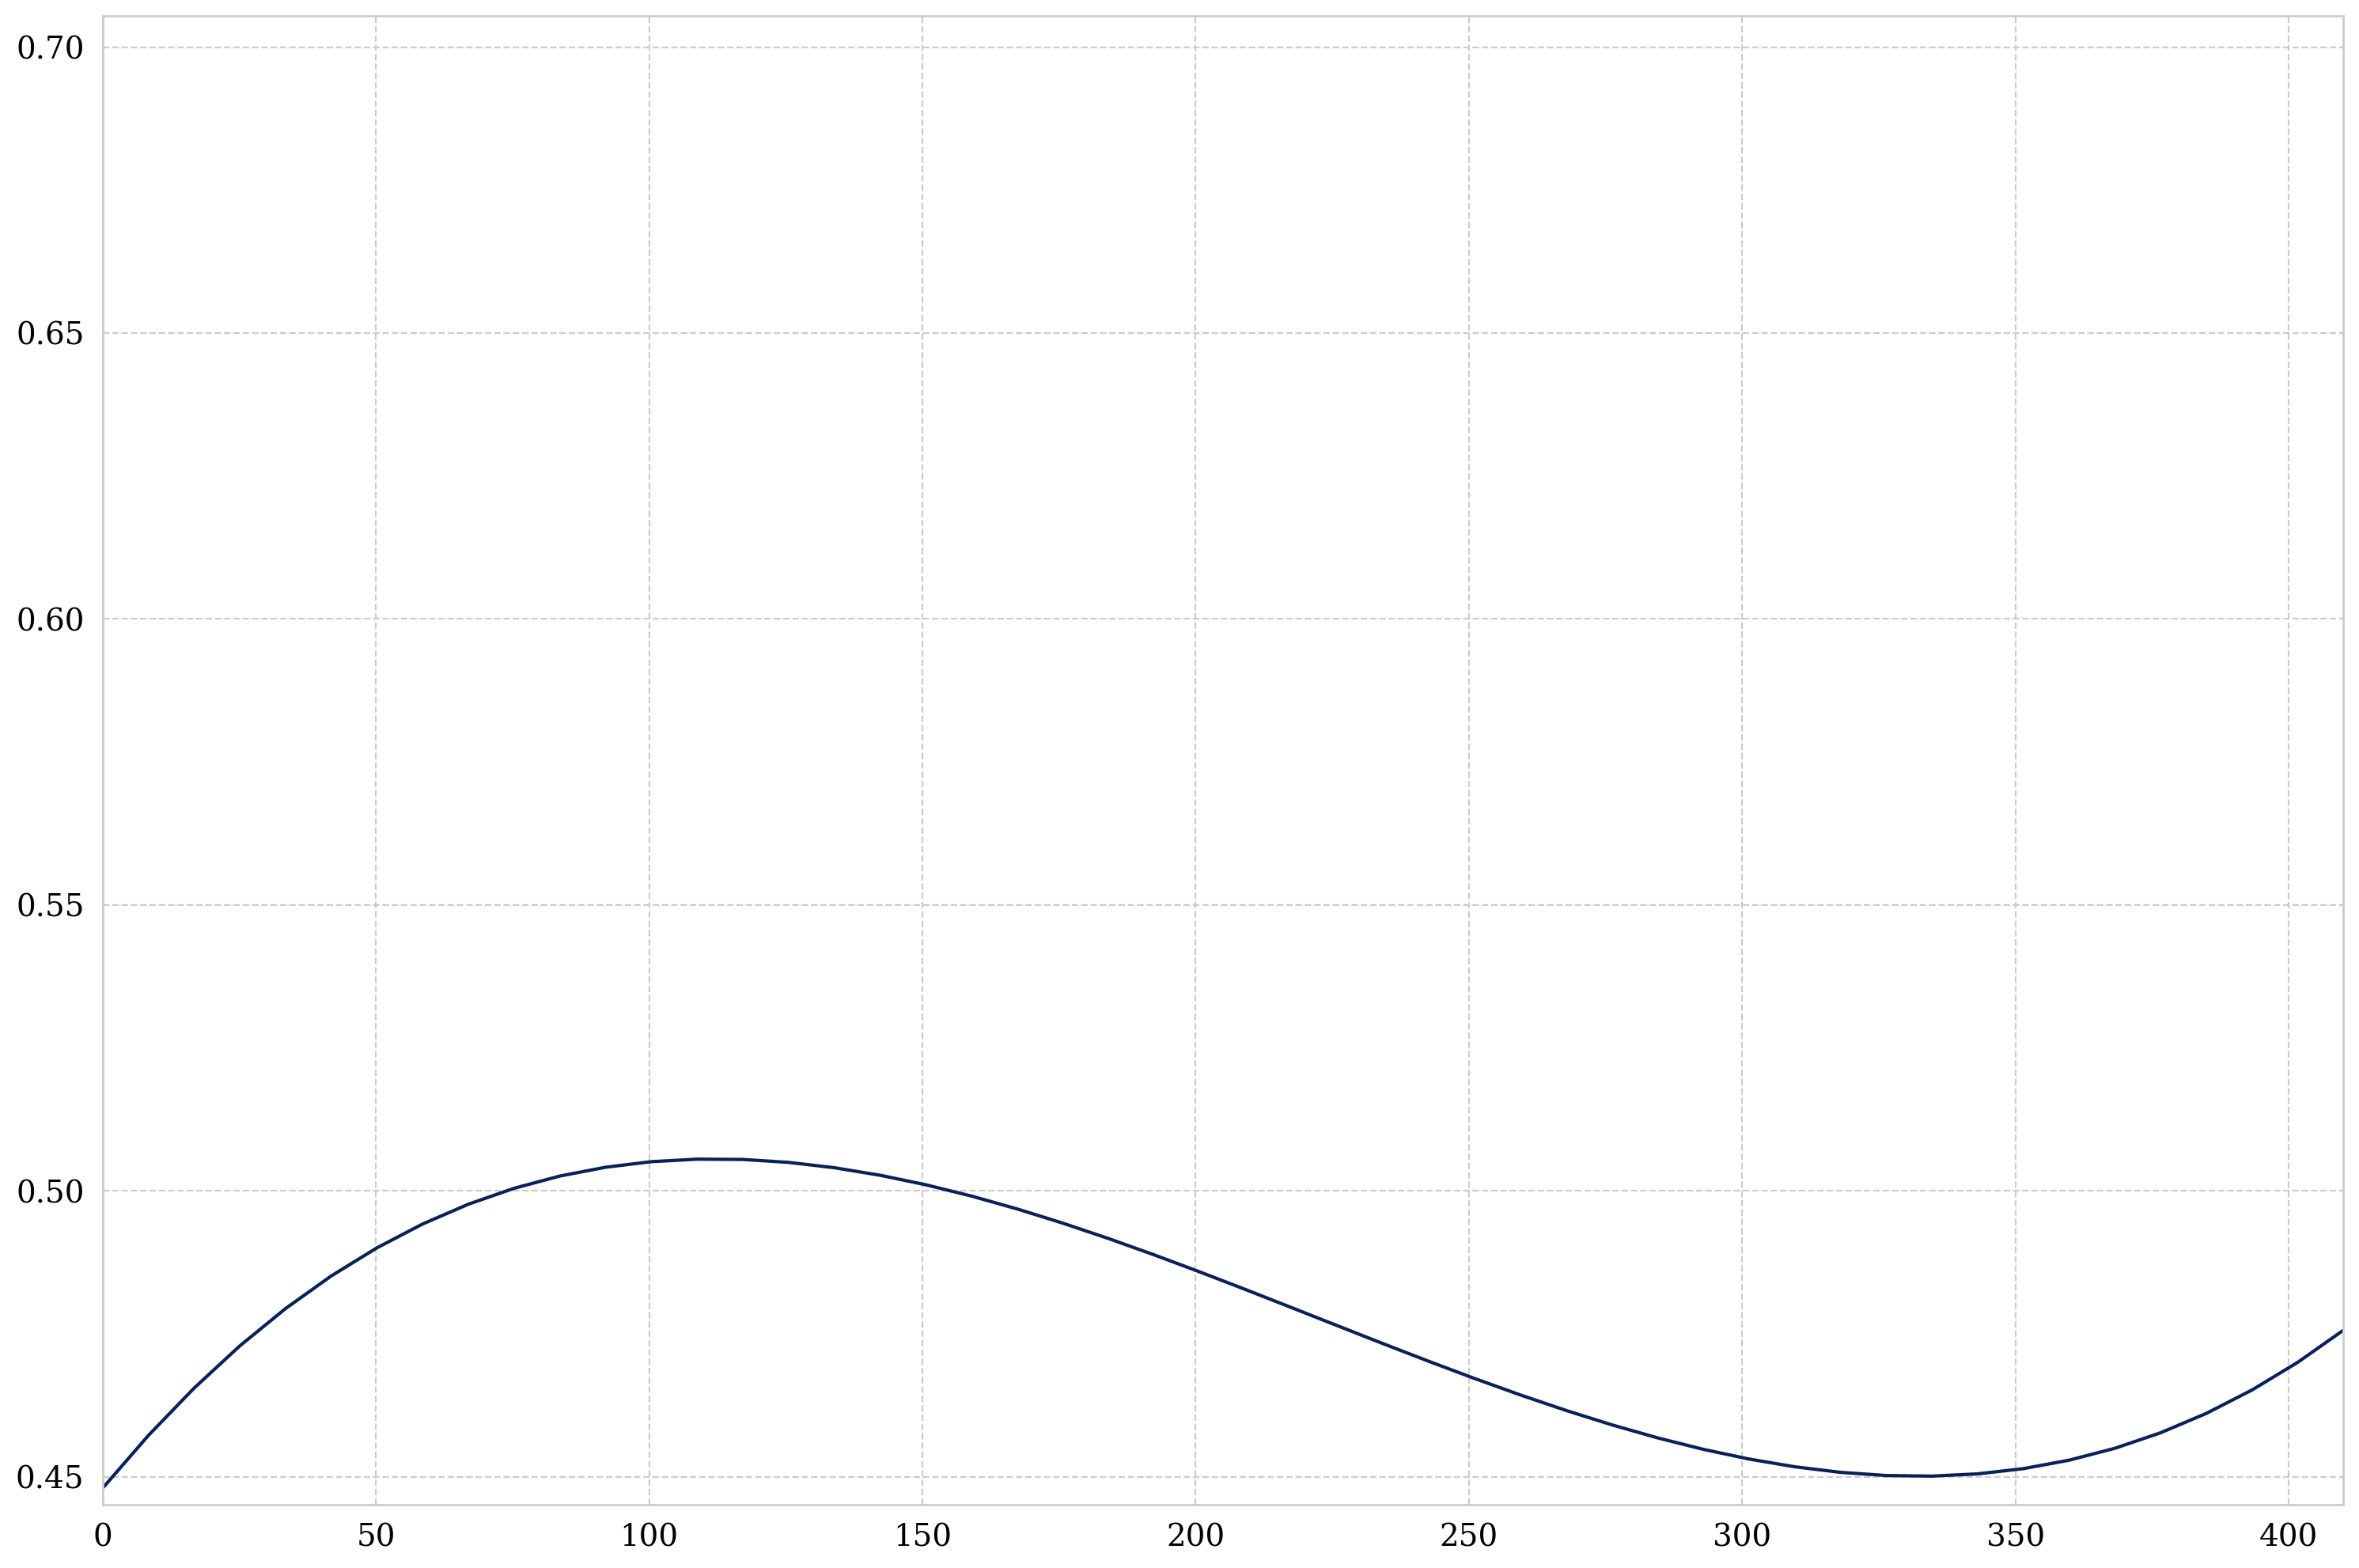

 
plot_2d_bins(two_d_plot_tw02)


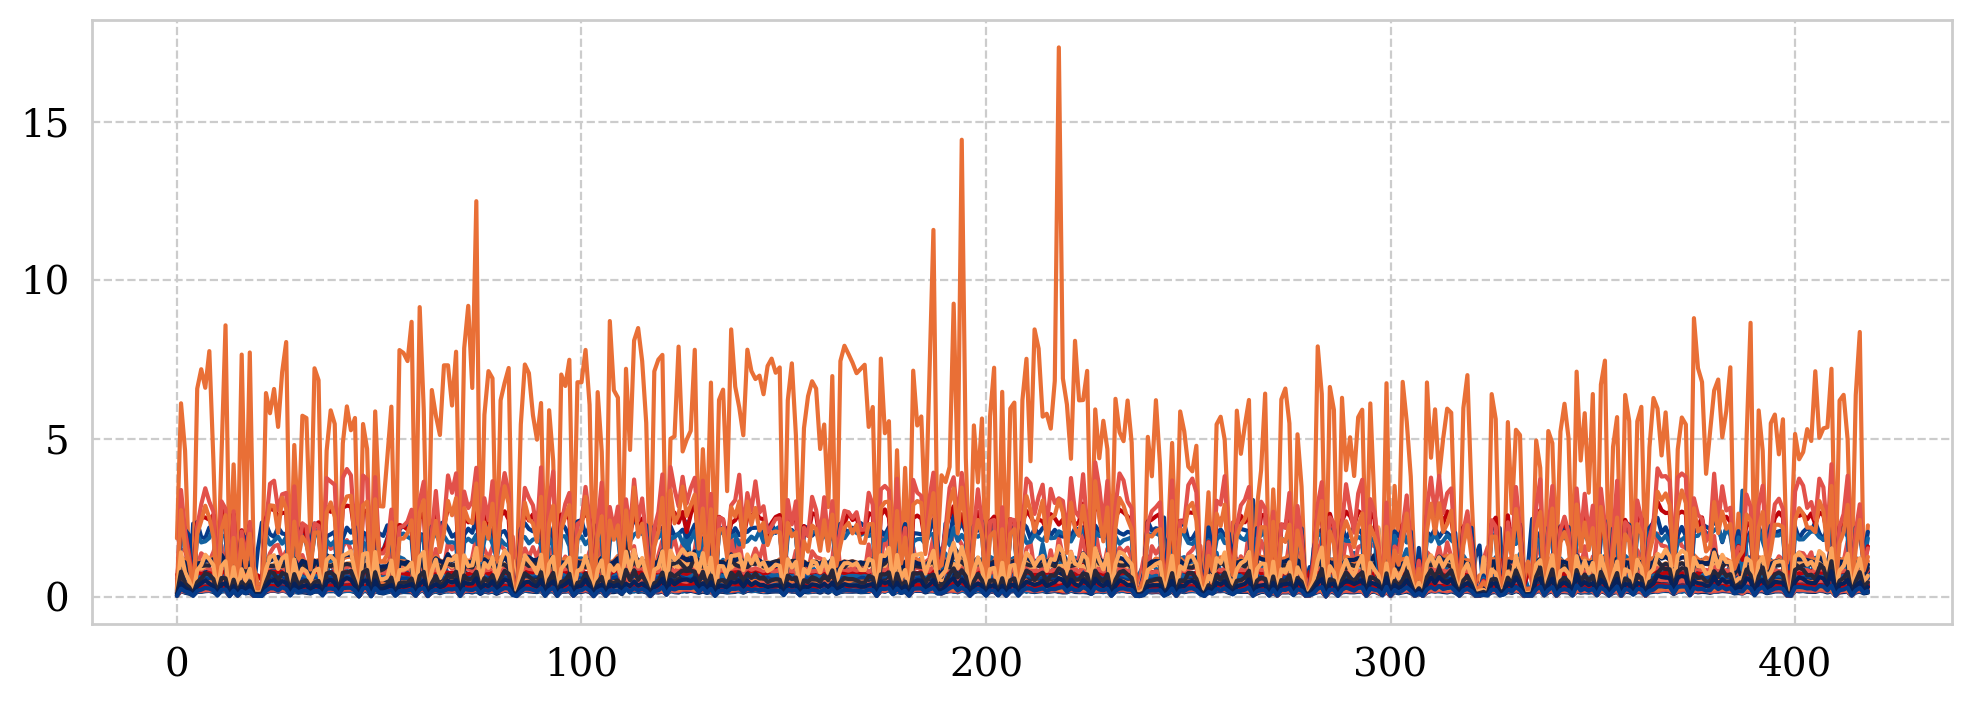

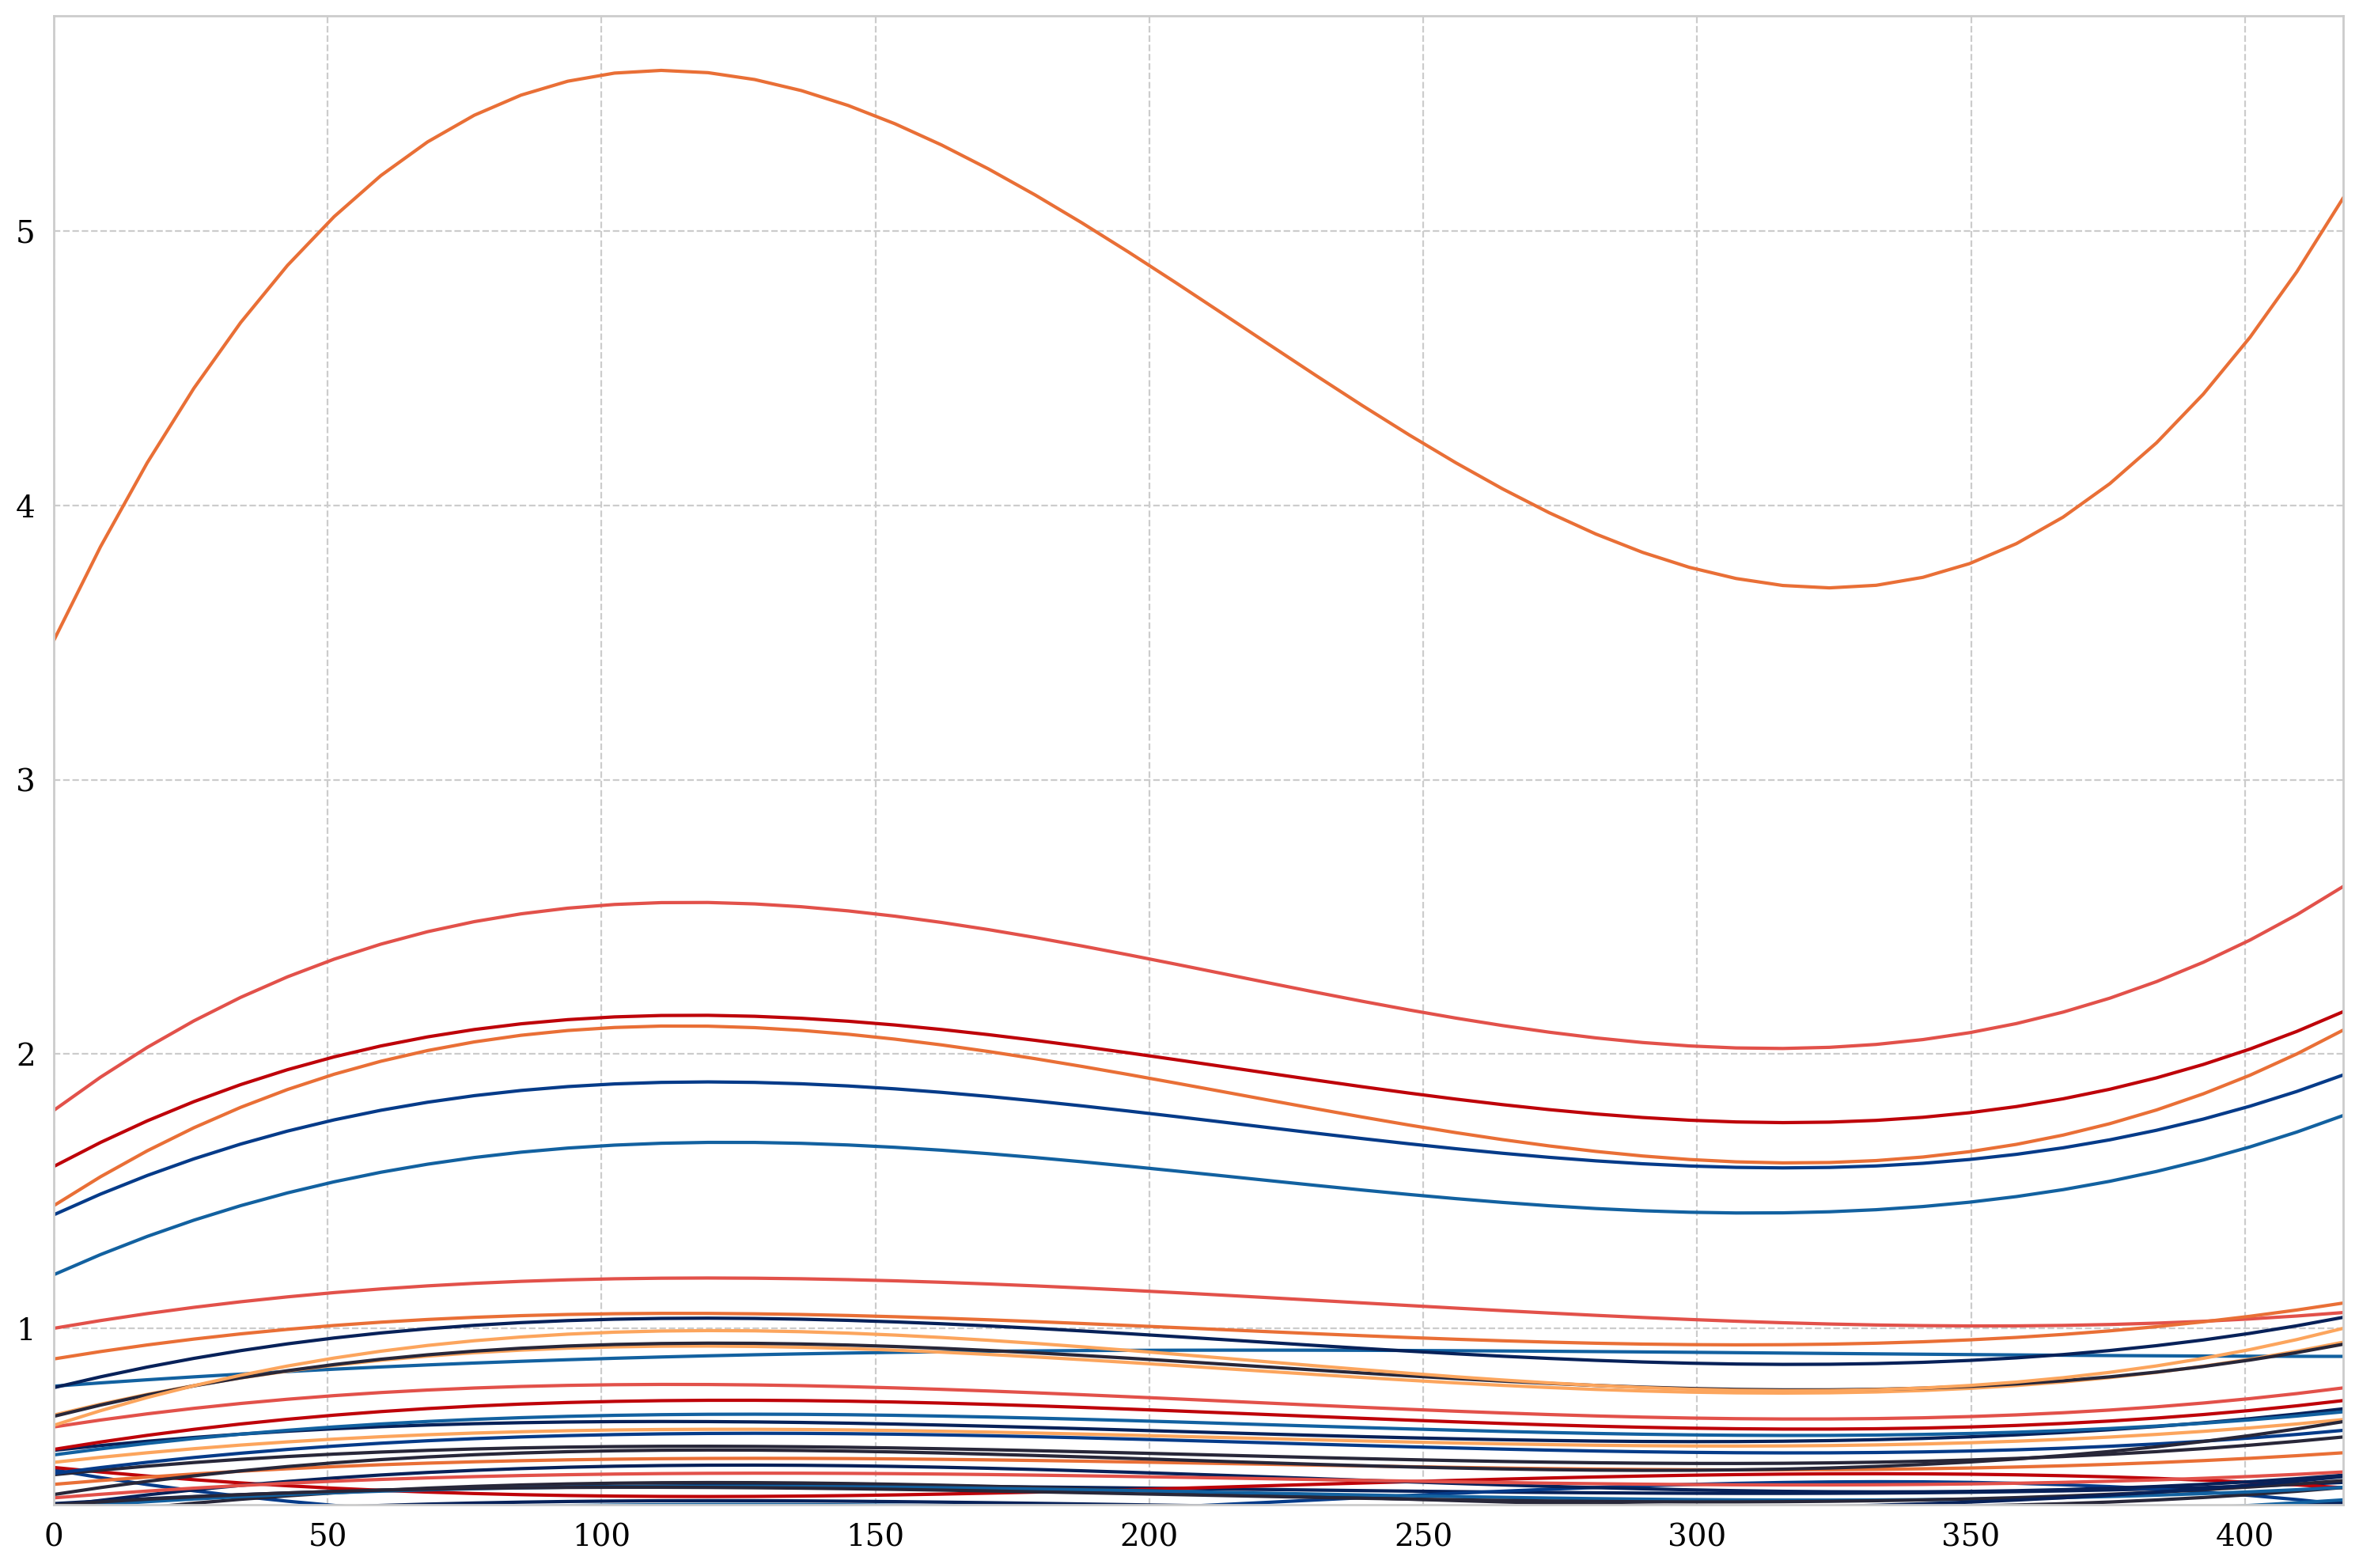

 
plot_2d_bins(two_d_plot_tw03)


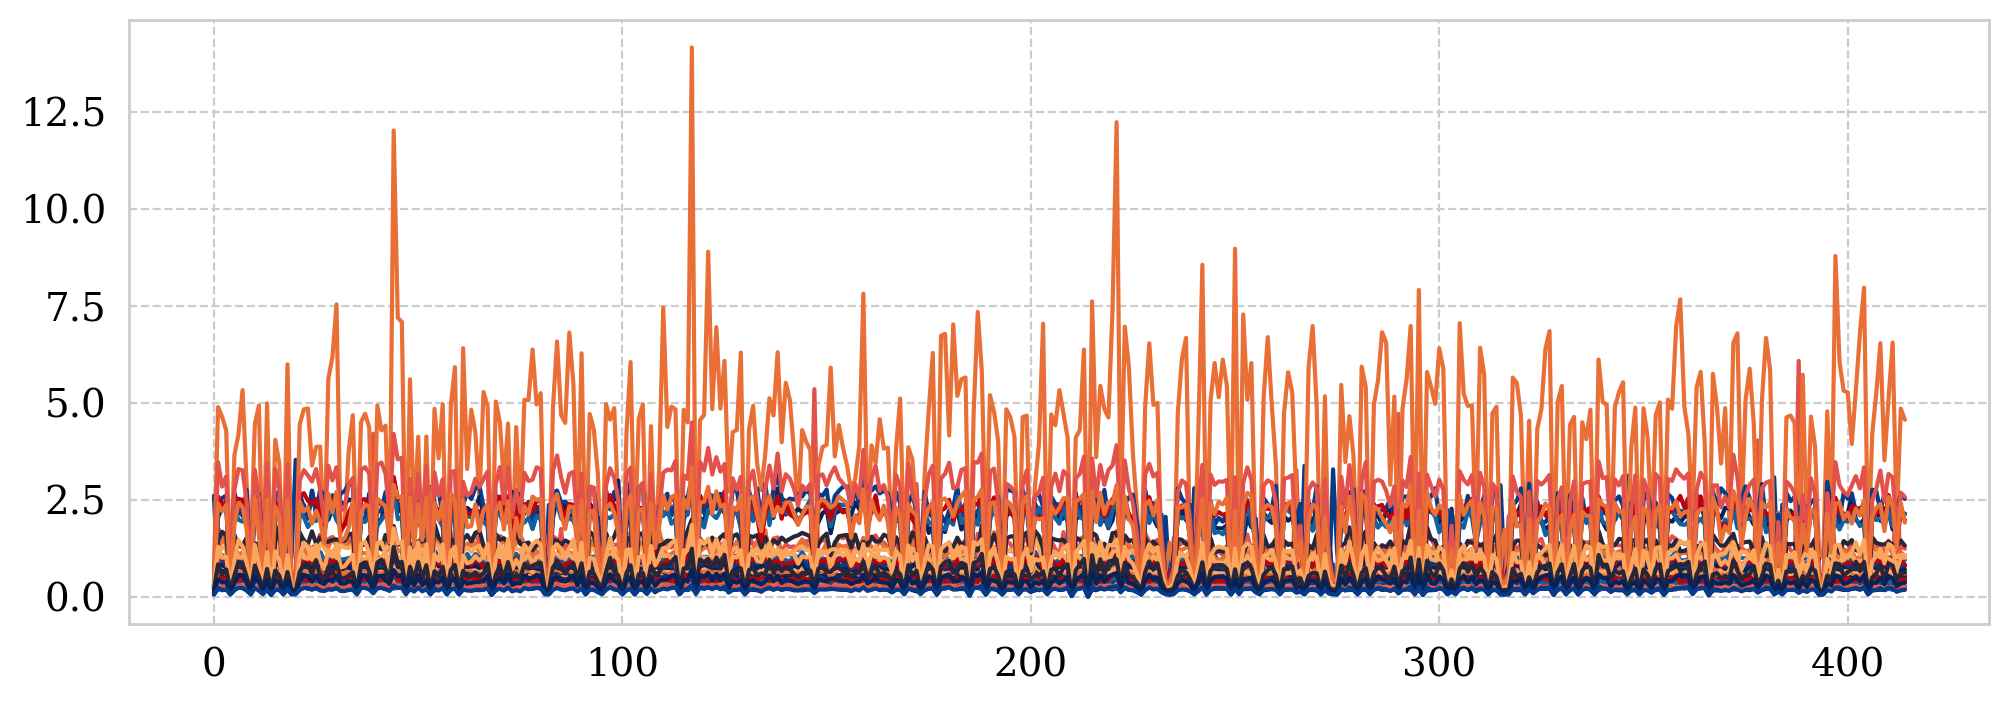

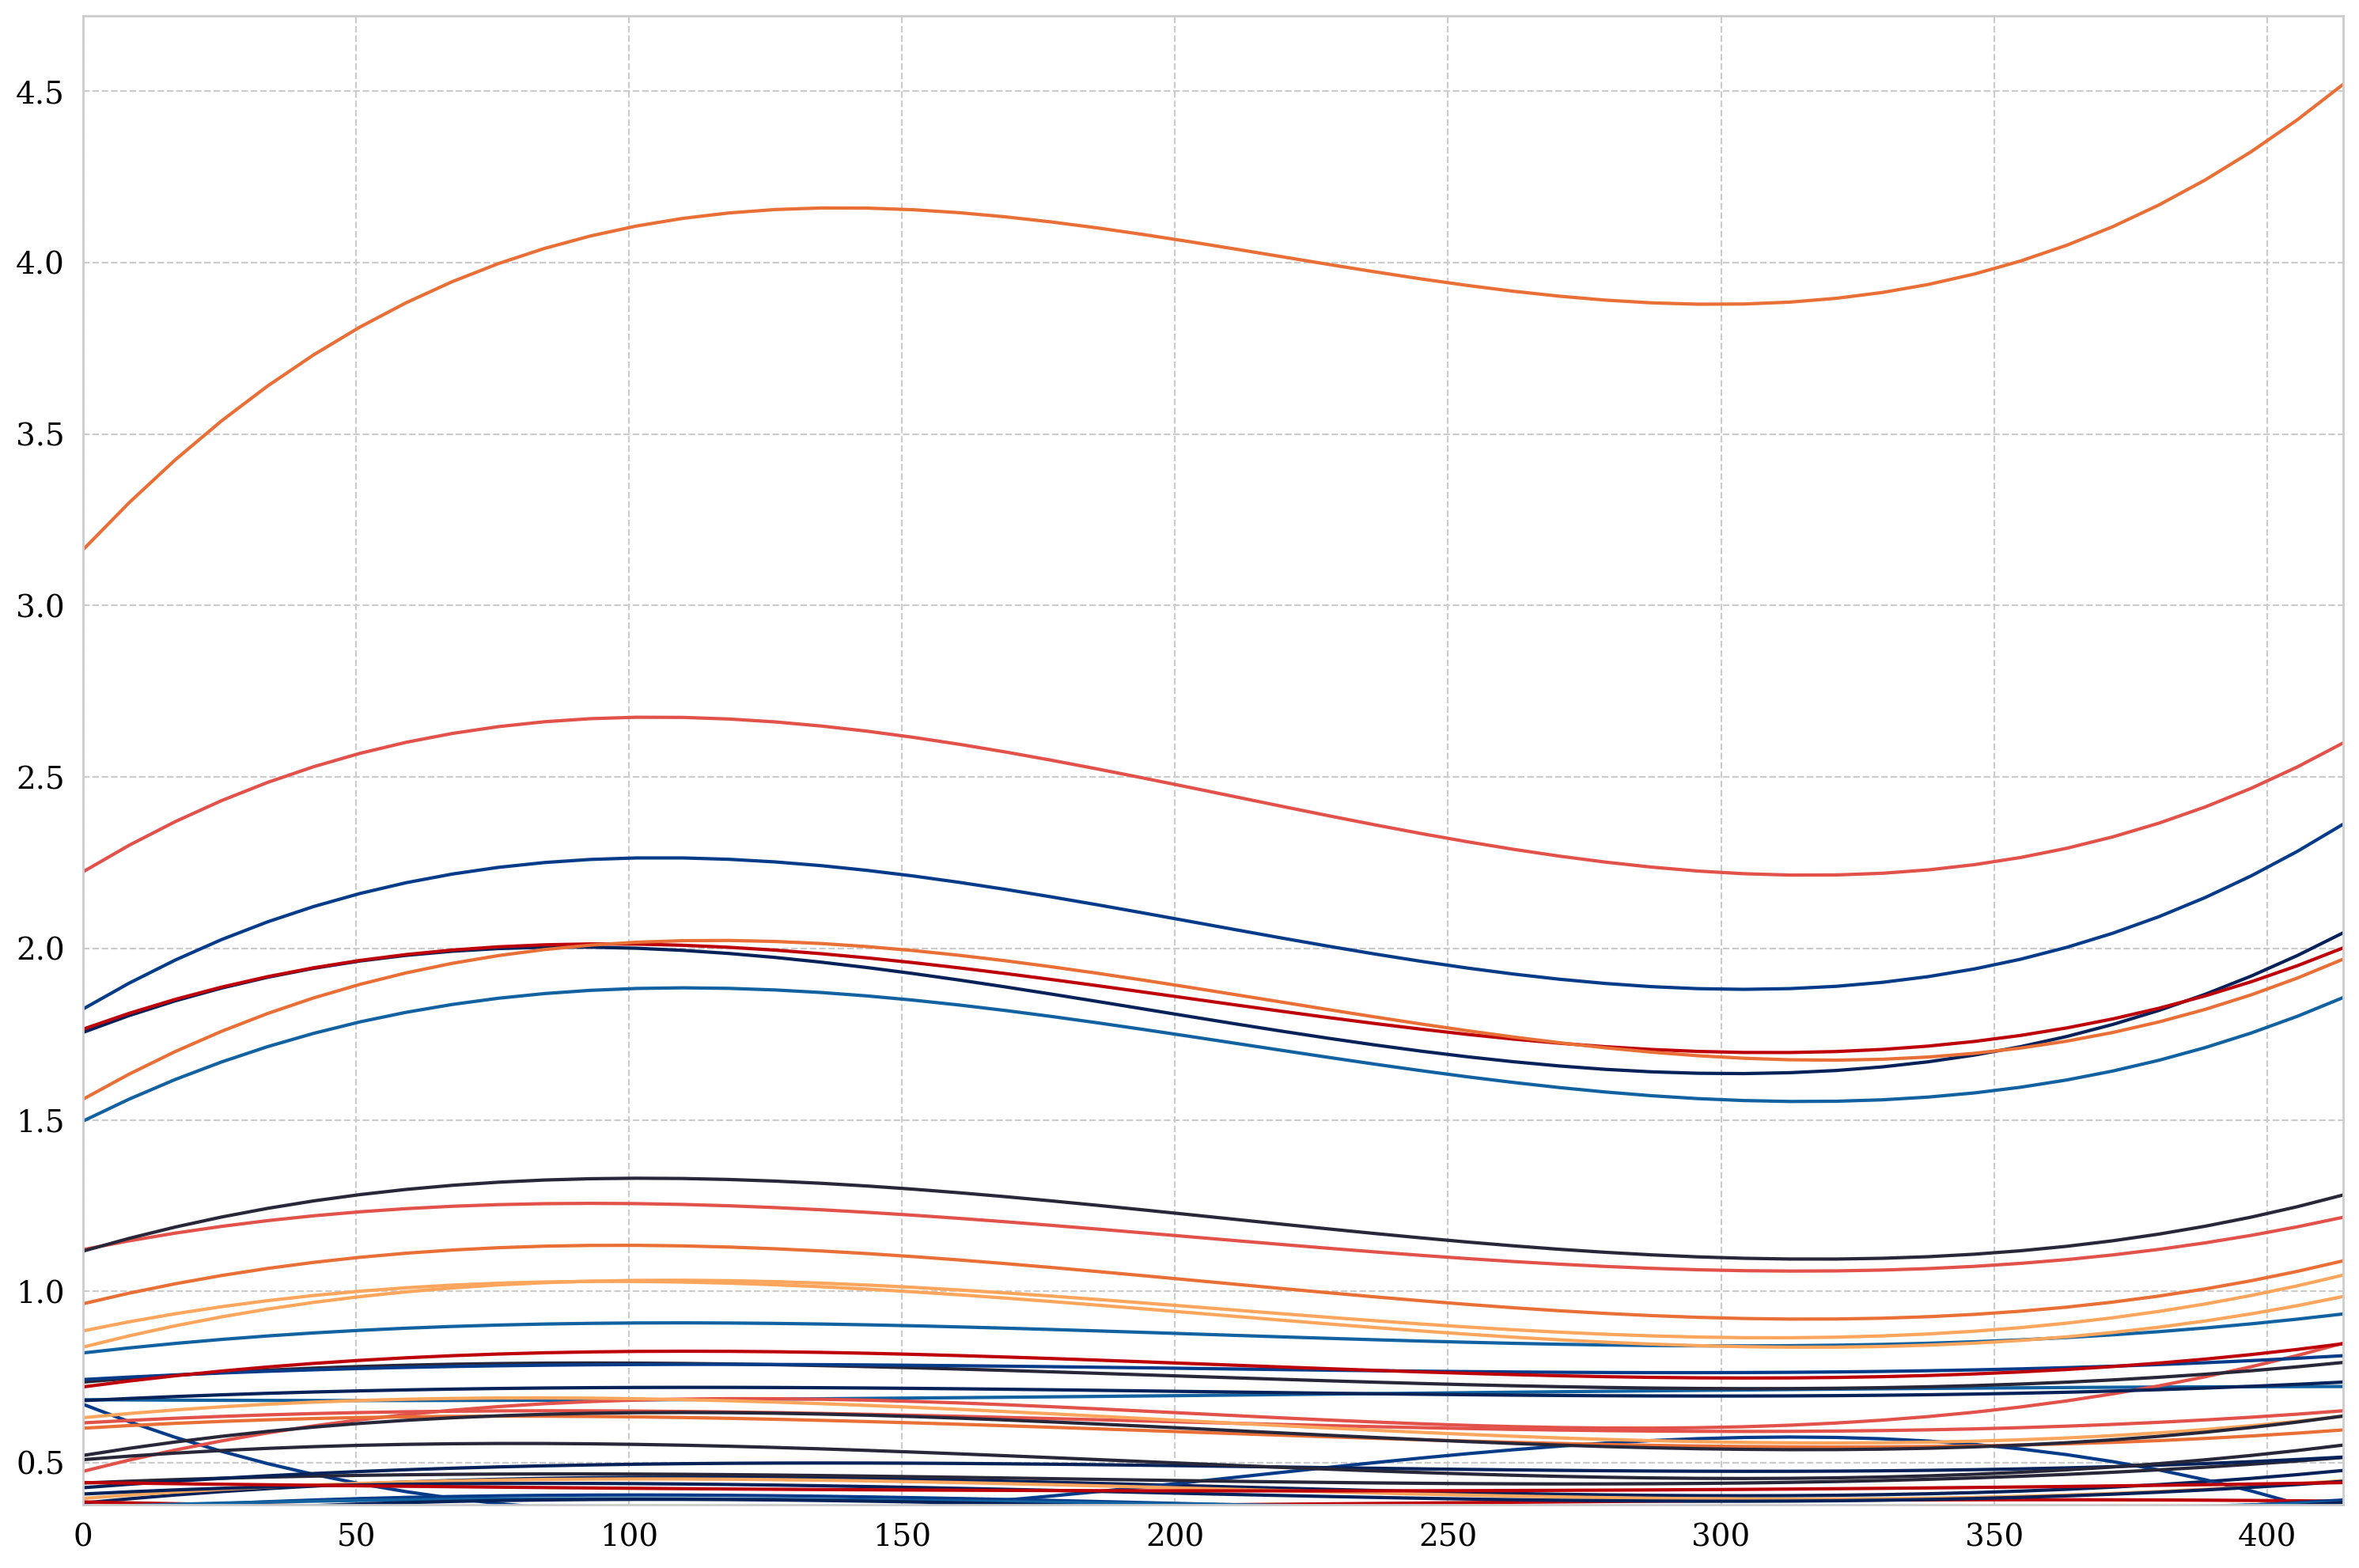

 
plot_2d_bins(two_d_plot_tw04)


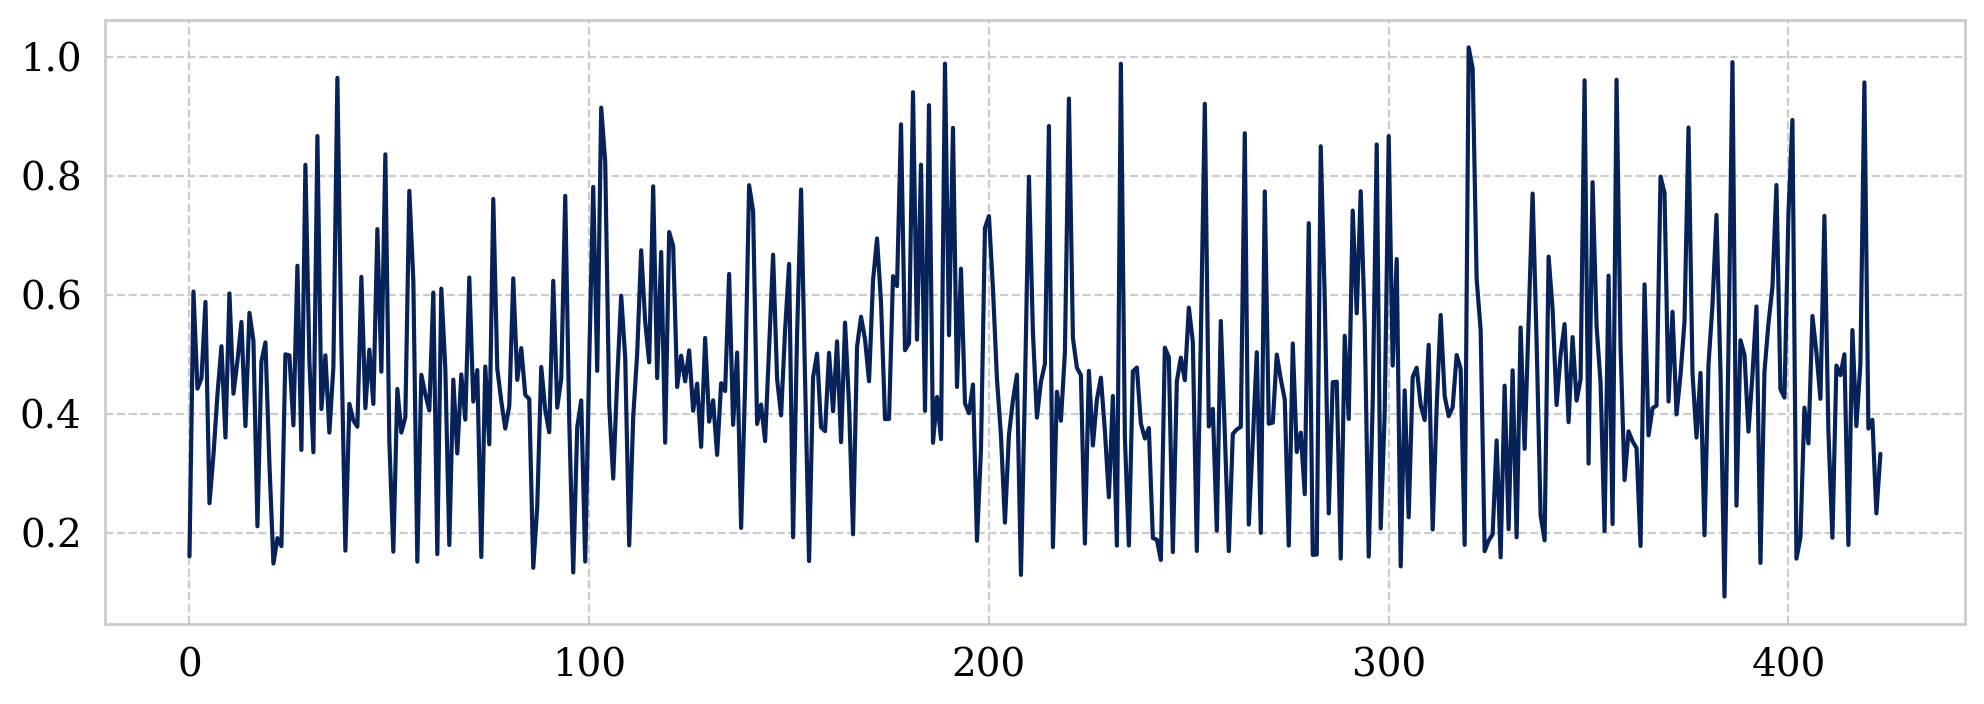

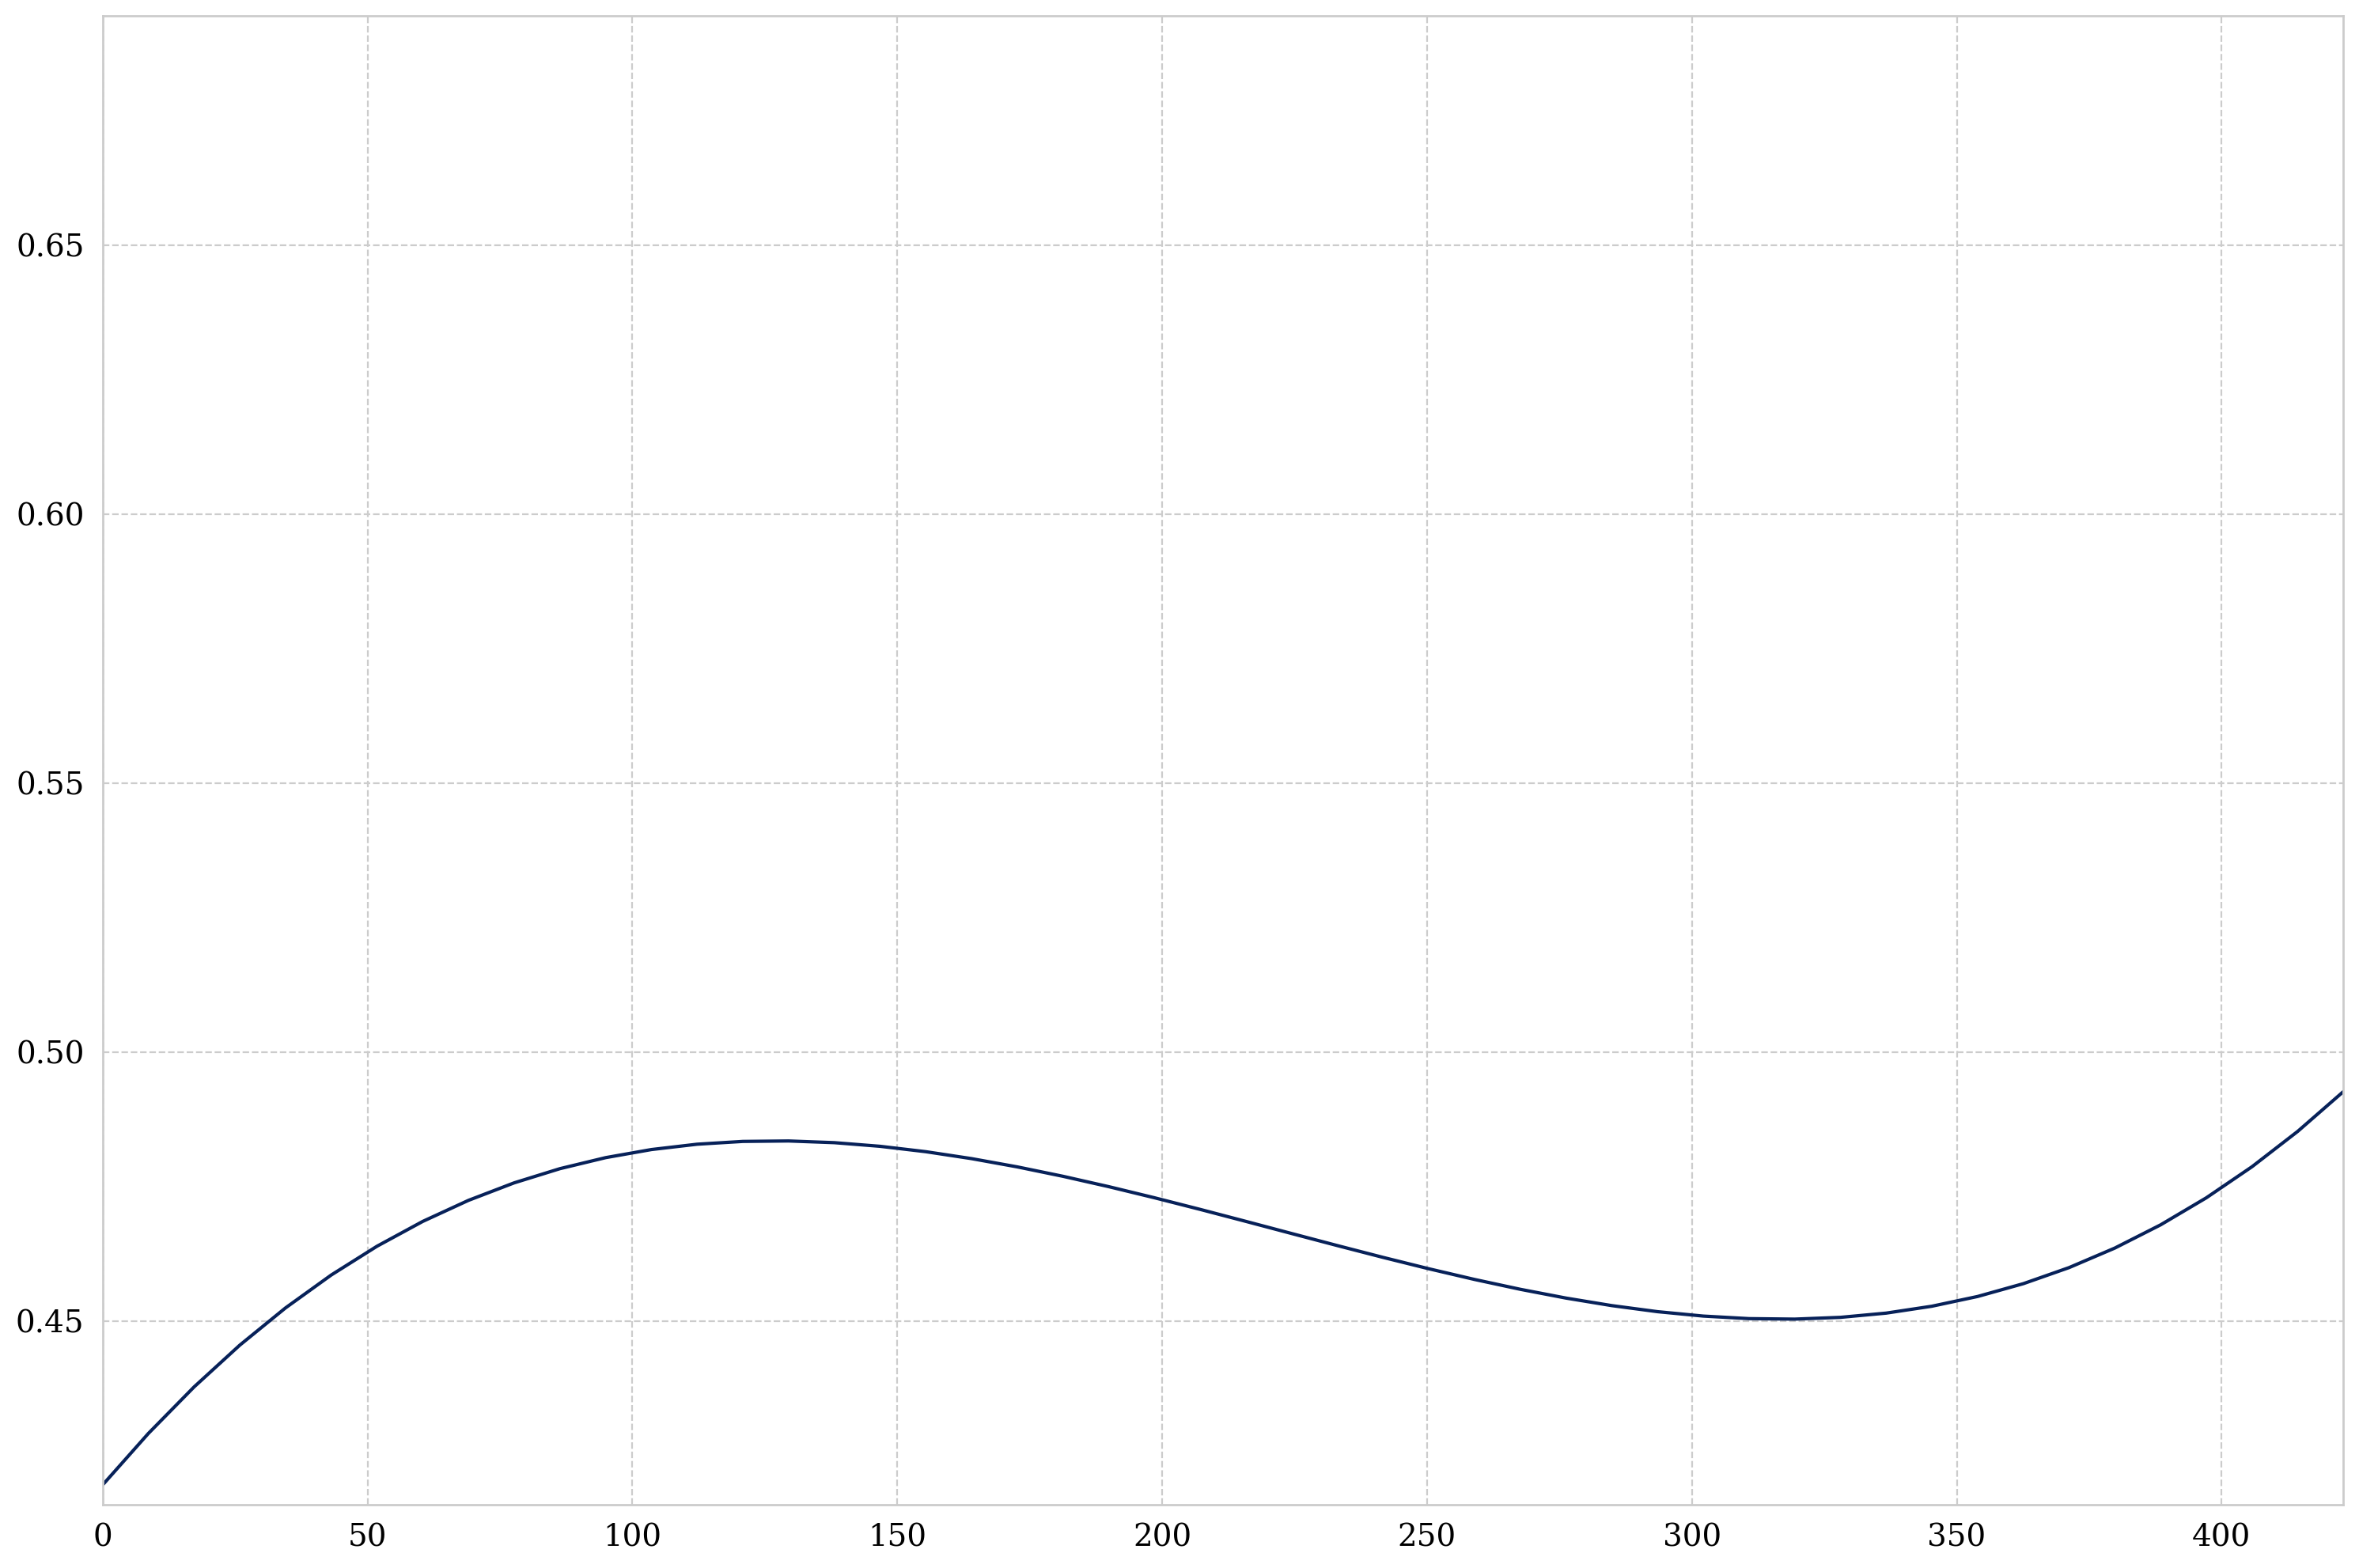

In [32]:
from labellines import labelLine, labelLines

print('plot_2d_bins(two_d_plot_ tw01)')
plot_2d_bins([two_d_plot_tw01[0]])
print(" ")
print('plot_2d_bins(two_d_plot_tw02)')
plot_2d_bins(two_d_plot_tw02)
print(" ")
print('plot_2d_bins(two_d_plot_tw03)')
plot_2d_bins(two_d_plot_tw03)
print(" ")
print('plot_2d_bins(two_d_plot_tw04)')
plot_2d_bins([two_d_plot_tw04[0]])

# Plotting 3D: Comparison
## The plots without filtering away the points that are above 10 (RMS amplitude)

- These points are just halved
- The darker the blue colour is, the higher the power production is

In [33]:
np.min(avg_powers_wt01)

388.6750183105

len(x):  411
len(y):  411
len(z):  411
411
3314.455810547


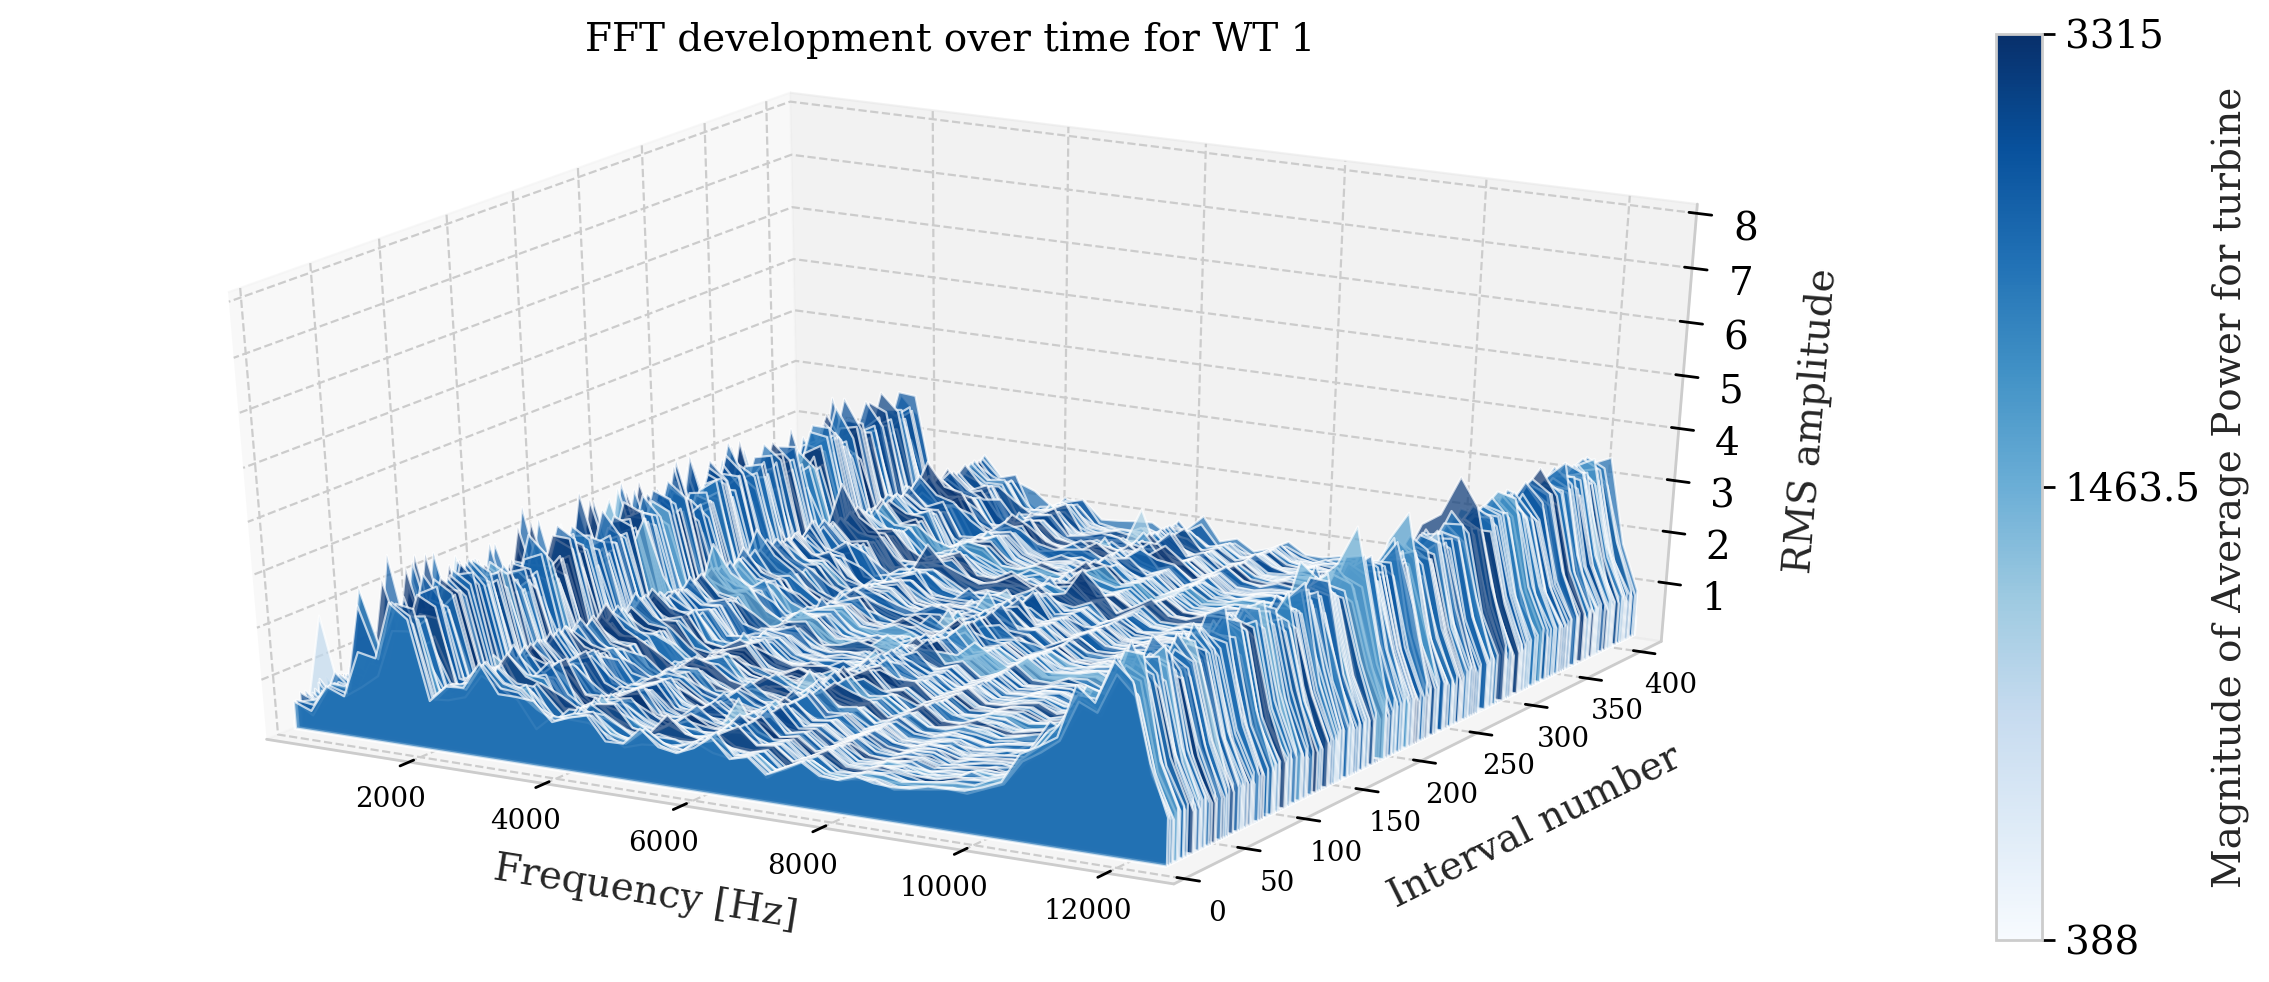

len(x):  419
len(y):  419
len(z):  419
419
3315.529296875


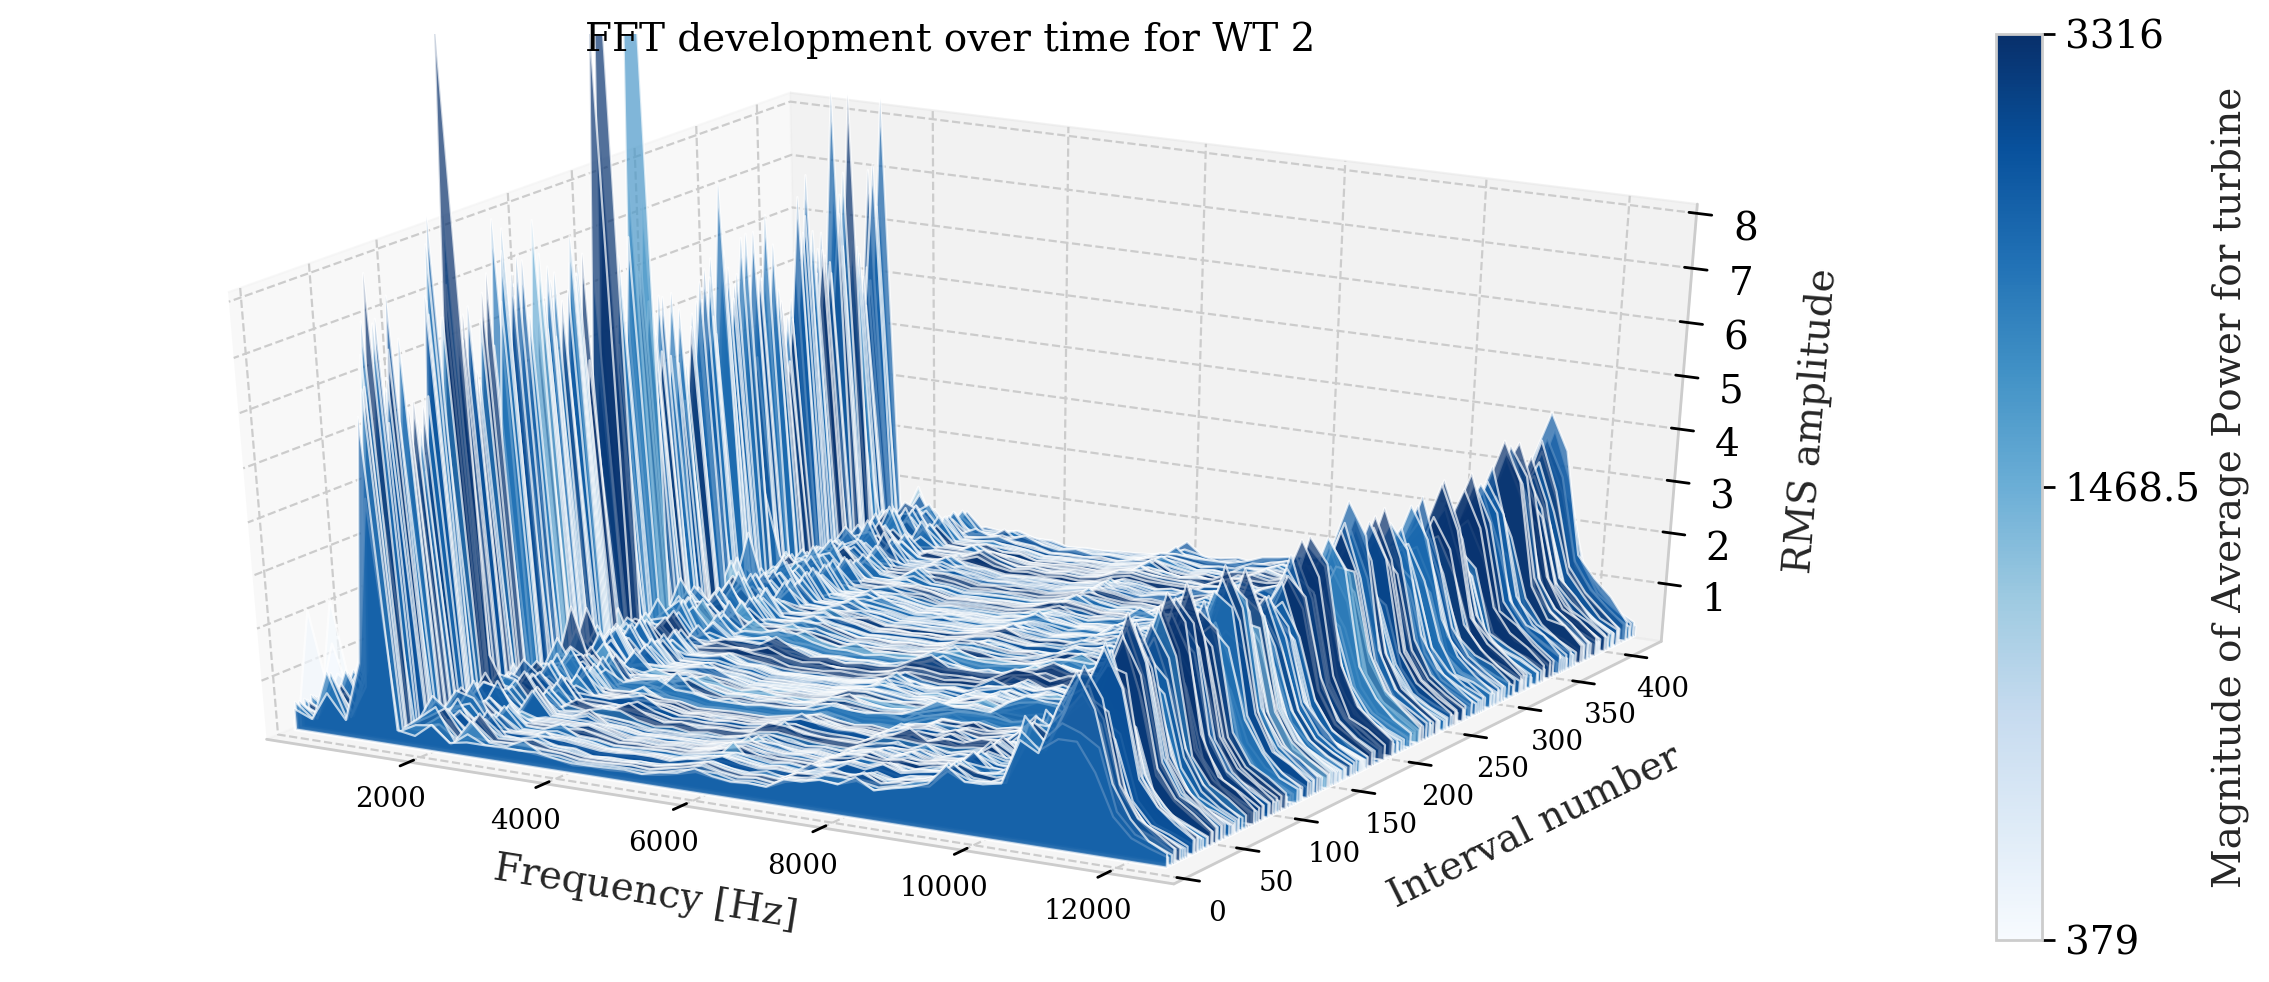

len(x):  415
len(y):  415
len(z):  415
415
3331.138427734


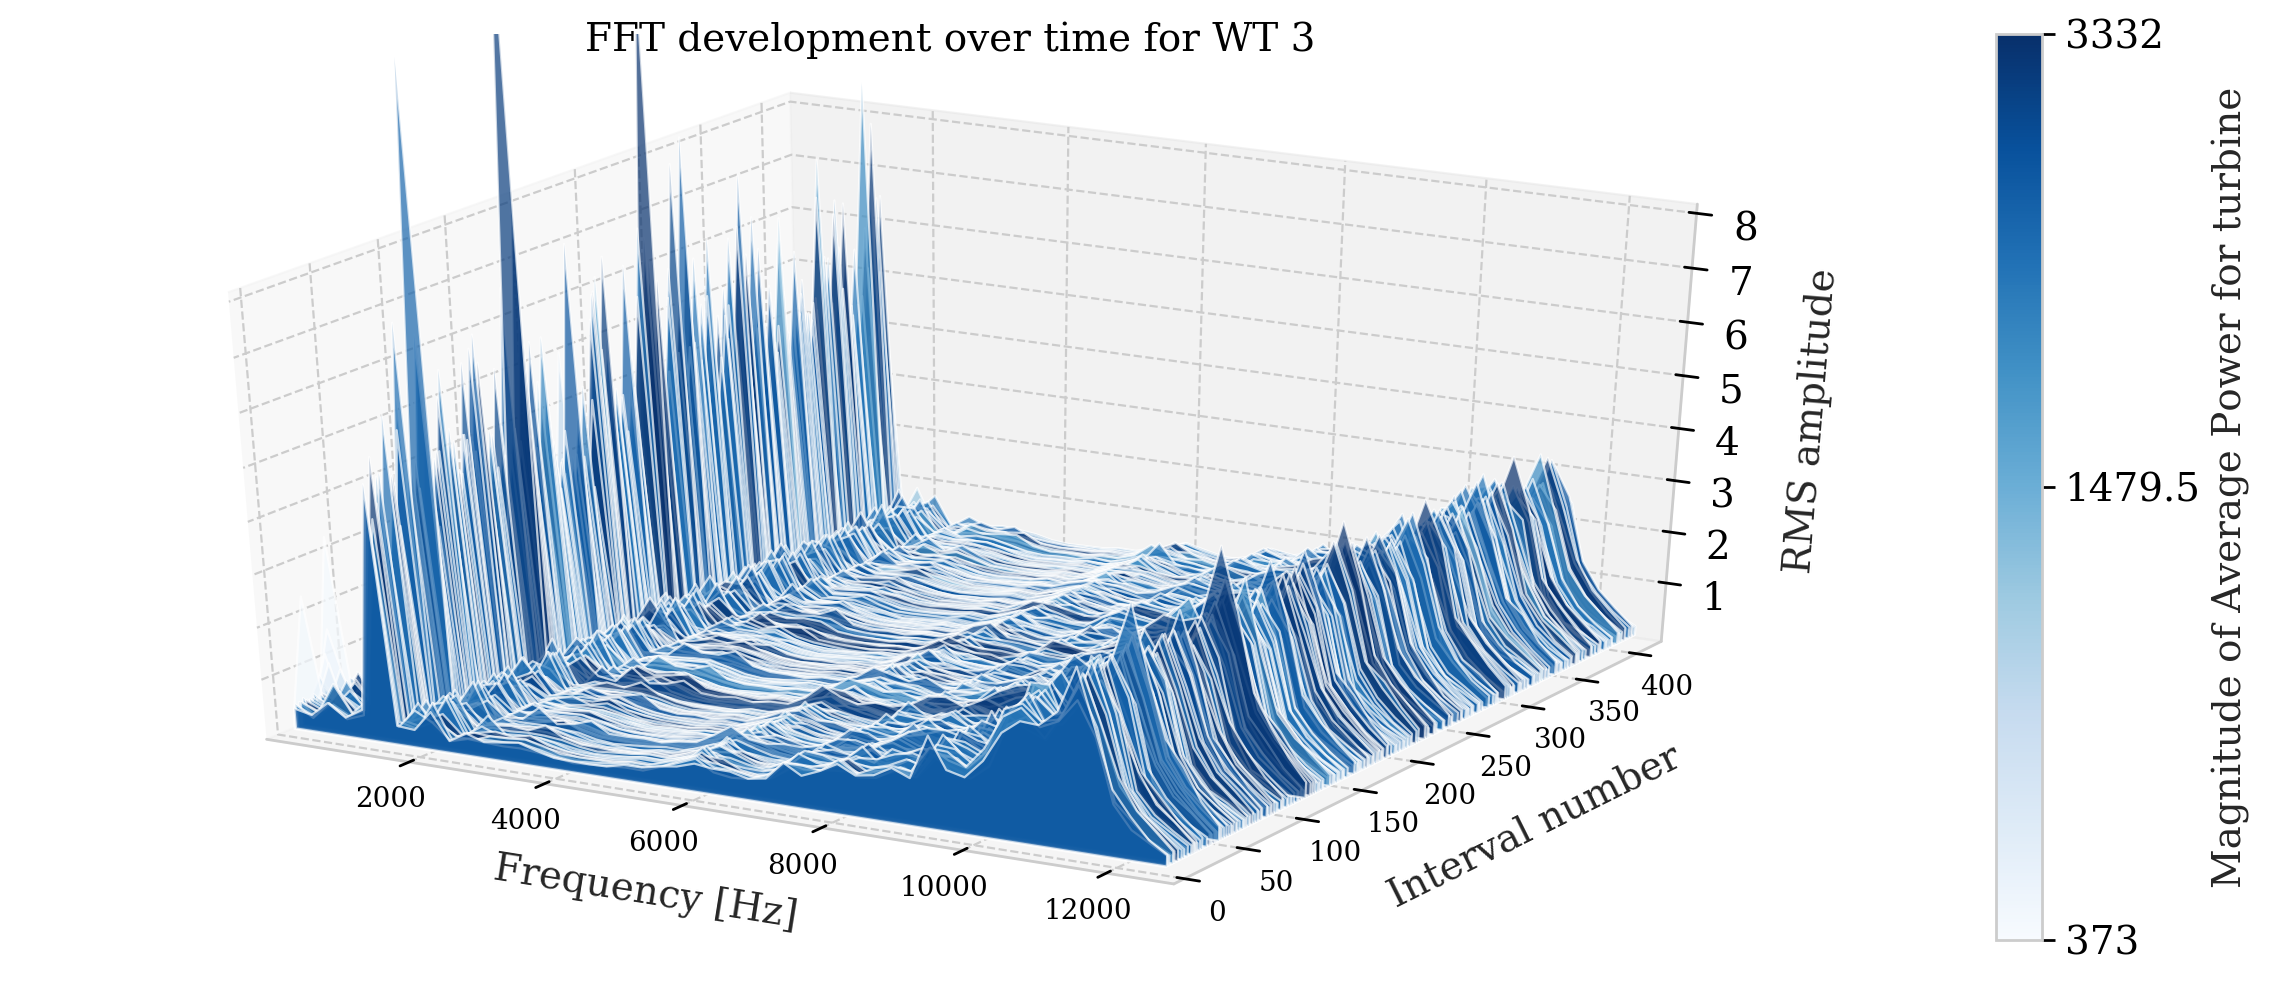

len(x):  424
len(y):  424
len(z):  424
424
3314.773193359


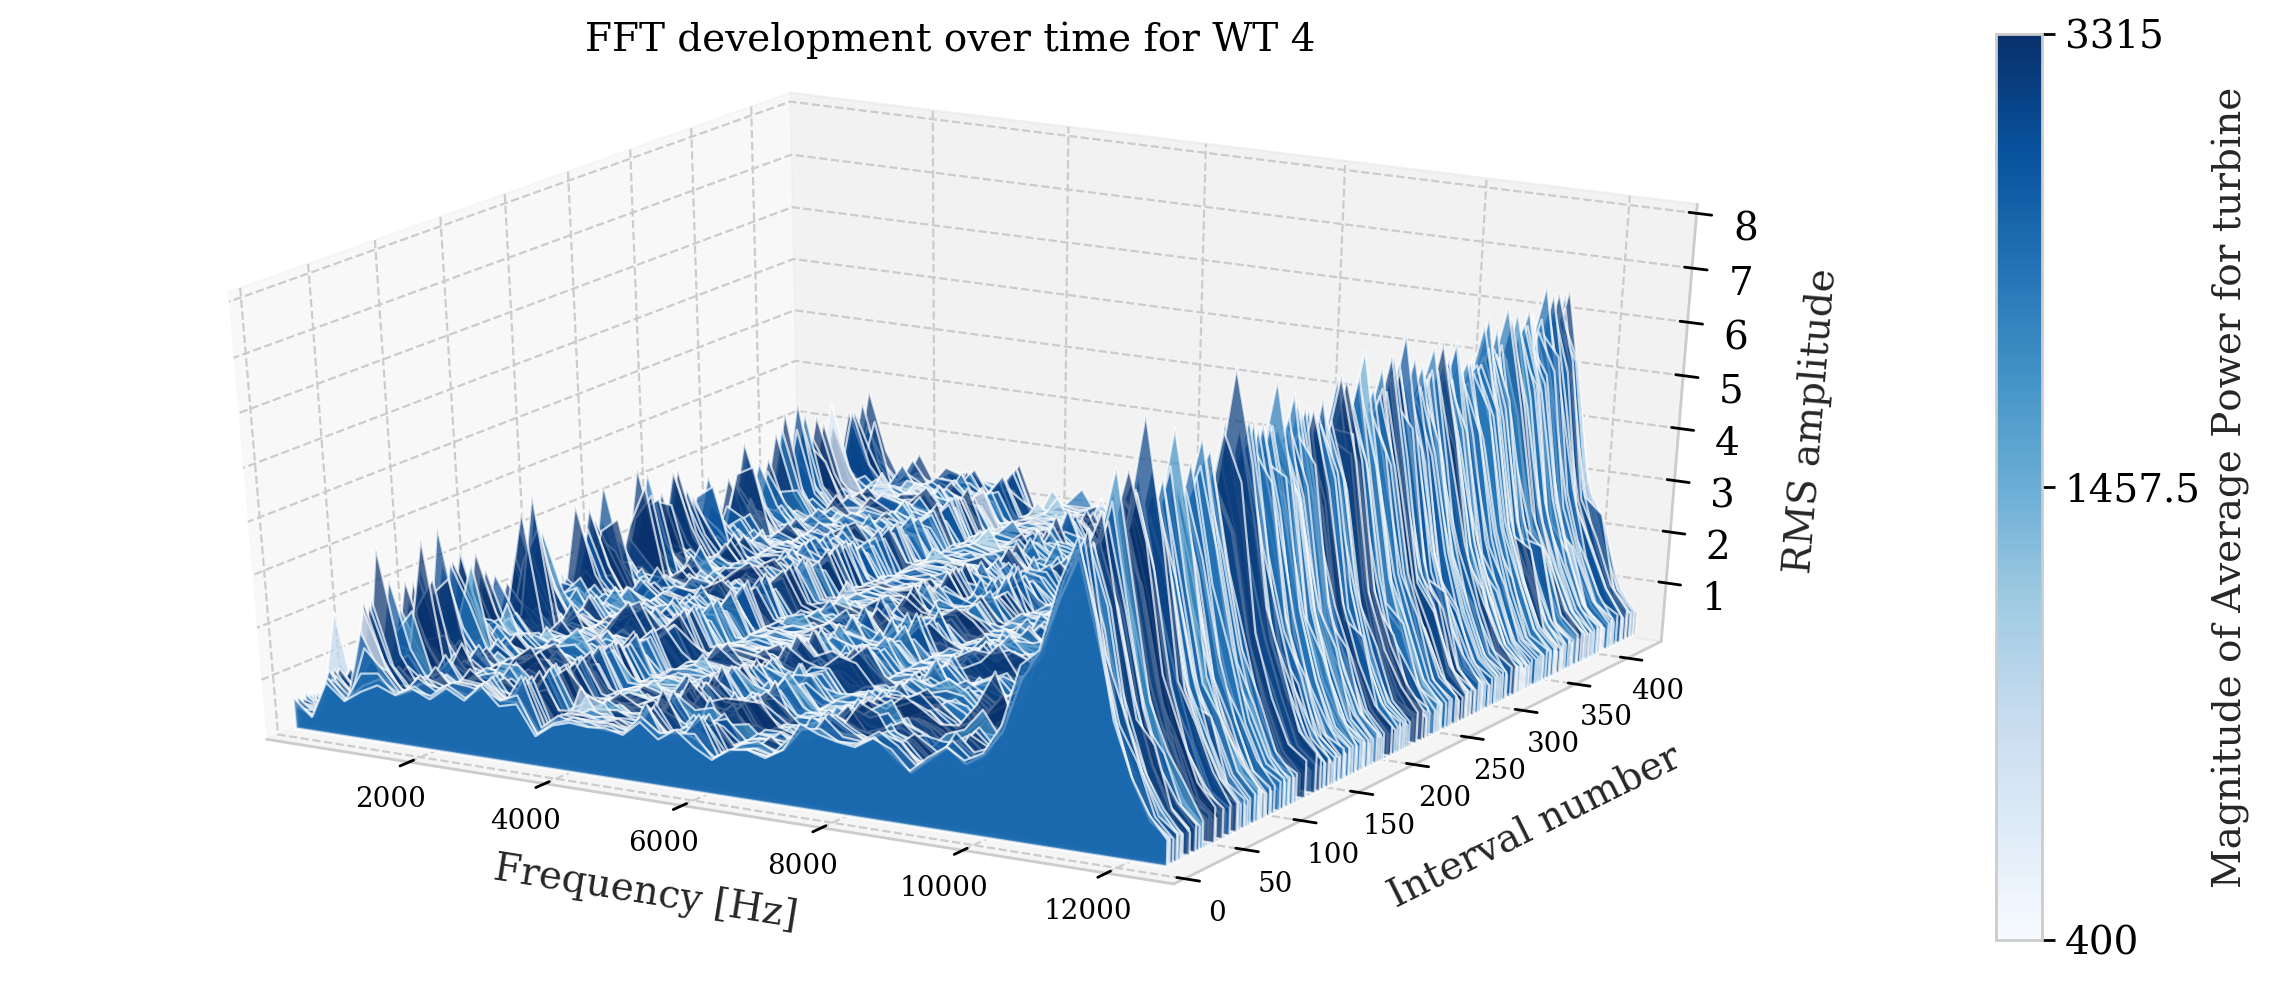

In [34]:
print3d_with_poly_collection("1",
                             remove_indexes_wt01,
                             freqs_wt01,
                             interval_nums_wt01, 
                             rms_amplitudes_wt01,
                             'color_alt4',
                             avg_powers_filtered_wt01,
                             'Blues',
                             False)

print3d_with_poly_collection("2",
                             remove_indexes_wt02,
                             freqs_wt02,
                             interval_nums_wt02, 
                             rms_amplitudes_wt02,
                             'color_alt4',
                             avg_powers_filtered_wt02,
                             'Blues',
                             False)

print3d_with_poly_collection("3",
                             remove_indexes_wt03,
                             freqs_wt03,
                             interval_nums_wt03, 
                             rms_amplitudes_wt03,
                             'color_alt4',
                             avg_powers_filtered_wt03,
                             'Blues',
                             False)

print3d_with_poly_collection("4",
                             remove_indexes_wt04,
                             freqs_wt04,
                             interval_nums_wt04, 
                             rms_amplitudes_wt04,
                             'color_alt4',
                             avg_powers_filtered_wt04,
                             'Blues',
                             False)

In [35]:
print3d_with_poly_collection("1",
                             freqs_wt01,
                             interval_nums_wt01, 
                             rms_amplitudes_wt01,
                             'color_alt4',
                             avg_powers_filtered_wt01,
                             'Blues',
                             True)

print3d_with_poly_collection("2",
                             freqs_wt02,
                             interval_nums_wt02, 
                             rms_amplitudes_wt02,
                             'color_alt4',
                             avg_powers_filtered_wt02,
                             'Blues',
                              True)

print3d_with_poly_collection("3",
                             freqs_wt03,
                             interval_nums_wt03, 
                             rms_amplitudes_wt03,
                             'color_alt4',
                             avg_powers_filtered_wt03,
                             'Blues',
                              True)

print3d_with_poly_collection("4",
                             freqs_wt04,
                             interval_nums_wt04, 
                             rms_amplitudes_wt04,
                             'color_alt4',
                             avg_powers_filtered_wt04,
                             'Blues',
                              True)

len(x):  127
len(y):  127


/Users/stianismar/Dropbox/gitProsjekter/master-thesis/venv/lib/python3.7/site-packages/ipykernel_launcher.py:19: DeprecationWarning: using a non-integer array as obj in delete will result in an error in the future
/Users/stianismar/Dropbox/gitProsjekter/master-thesis/venv/lib/python3.7/site-packages/ipykernel_launcher.py:19: DeprecationWarning: in the future out of bounds indices will raise an error instead of being ignored by `numpy.delete`.
/Users/stianismar/Dropbox/gitProsjekter/master-thesis/venv/lib/python3.7/site-packages/ipykernel_launcher.py:20: DeprecationWarning: using a non-integer array as obj in delete will result in an error in the future
/Users/stianismar/Dropbox/gitProsjekter/master-thesis/venv/lib/python3.7/site-packages/ipykernel_launcher.py:20: DeprecationWarning: in the future out of bounds indices will raise an error instead of being ignored by `numpy.delete`.
/Users/stianismar/Dropbox/gitProsjekter/master-thesis/venv/lib/python3.7/site-packages/ipykernel_launcher.

TypeError: len() of unsized object

## Plotting RMS (y-axis) agains ROT speed (x-axis)

In [ ]:
def scatter_plot_rms_rot_speed(bin_list, wt_num): # Takes in how many bin you want to have studied
    try:
        wt_num = wt_num.split('0')[1]
        
    except:
        print("wt_num is not the wrong format")
    
    if wt_num == "1":
        two_d_plot_tw = two_d_plot_tw01
        avg_rot_speeds = avg_rot_speeds1
    if wt_num == "2":
        two_d_plot_tw = two_d_plot_tw02
        avg_rot_speeds = avg_rot_speeds2
    if wt_num == "3":
        two_d_plot_tw = two_d_plot_tw03
        avg_rot_speeds = avg_rot_speeds3
    if wt_num == "4":
        two_d_plot_tw = two_d_plot_tw04
        avg_rot_speeds = avg_rot_speeds4
        
    fig = plt.figure()
    
    max_rms_val = 0
    
    for bin_num in bin_list:
        
        if len(two_d_plot_tw[bin_num]) == len(avg_rot_speeds):
            ax = fig.add_subplot(1,1,1)
            ax.scatter(avg_rot_speeds,two_d_plot_tw[bin_num])
            check_max = np.max(two_d_plot_tw[bin_num])
            max_rms_val = check_max if max_rms_val < check_max else max_rms_val
        else:
            print(f"The shape is not the same. {len(two_d_plot_tw)} =! {len(avg_rot_speeds)}'")
    legend_labels = ['Bin ' + str(elem) for i, elem in enumerate(bin_list)]
    ax.legend(labels=legend_labels,loc='upper left',
             markerscale=2.,fontsize=10)
    plt.margins(0)
    plt.title(f"RMS and RPM correlation for WT {wt_num}" "\n" f"Frequency range: [{bin_list[0]*256},{bin_list[-1]*256}] Hz")

    plt.ylim(0,max_rms_val+1)
    plt.xlim(0,1650)
    plt.xlabel("Mean RPM")
    plt.ylabel("RMS")
    plt.show()

In [ ]:
import warnings
warnings.simplefilter('ignore')

def scatter_plot_rms_rot_speed_time(bin_list, wt_num): # Takes in how many bin you want to have studied
    try:
        wt_num = wt_num.split('0')[1]
    except:
        print("wt_num is not the wrong format")
    
    if wt_num == "1":
        two_d_plot_tw = two_d_plot_tw01
        avg_rot_speeds = avg_rot_speeds1
    if wt_num == "2":
        two_d_plot_tw = two_d_plot_tw02
        avg_rot_speeds = avg_rot_speeds2
    if wt_num == "3":
        two_d_plot_tw = two_d_plot_tw03
        avg_rot_speeds = avg_rot_speeds3
    if wt_num == "4":
        two_d_plot_tw = two_d_plot_tw04
        avg_rot_speeds = avg_rot_speeds4
        
    fig = plt.figure()
    fig1 = plt.figure()
    
    max_rms_val = 0
    for bin_num in bin_list:
        
        if len(two_d_plot_tw[bin_num]) == len(avg_rot_speeds):
            ax = fig.add_subplot(1,1,1)
            ax1 = fig1.add_subplot(1,1,1)

            standardise_rms_rot_speed = [two_d_plot_tw[bin_num][i] / avg_rot_speeds[i] for i in range(len(avg_rot_speeds)) ]
            
            z = np.polyfit(np.arange(0,len(two_d_plot_tw[bin_num])), standardise_rms_rot_speed,1)
            f = np.poly1d(z)
            y_line =  f(np.arange(0,len(two_d_plot_tw[bin_num])))
            
            ax1.plot(y_line)
            
            ax.scatter( np.arange( 0,len(two_d_plot_tw[bin_num])),standardise_rms_rot_speed  )
            
            x = np.arange(0,len(two_d_plot_tw[bin_num]))
            x = [x[0],x[-1]]
            y_line = [y_line[0], y_line[-1]] # These can not be correct? look into this 
            ax1.scatter(x, y_line)
            
            check_max = np.max(standardise_rms_rot_speed)
            max_rms_val = check_max if max_rms_val < check_max else max_rms_val
        else:
            print(f"The shape is not the same. {len(two_d_plot_tw)} =! {len(avg_rot_speeds)}'")
    
    legend_labels = ['Bin ' + str(elem) for i, elem in enumerate(bin_list)]
    ax.legend(labels=legend_labels,loc='upper left',
             markerscale=2.,fontsize=10)
    
    ax1.legend(labels=legend_labels,loc='upper left',
             markerscale=2.,fontsize=10)
    plt.margins(0)
    ax.set_title(f"RMS and RPM correlation for WT {wt_num}" "\n" f"Frequency range: [{bin_list[0]*256},{bin_list[-1]*256}] Hz")

    ax.set_ylim(0,max_rms_val+0.001)
    ax.set_xlim(0,np.ceil(len(two_d_plot_tw[bin_num])))
    
    ax.set_xlabel("Interval Number")
    ax1.set_xlabel("Interval Number")

    ax.set_ylabel("RMS / Avg. Speed")
    ax1.set_ylabel("RMS / Avg. Speed")

    plt.show()
    
bin_steps = np.arange(0,50,5)
steps = bin_steps[1]-bin_steps[0]
# bin_steps = [0,5,15,20,25,]
for step in bin_steps:    
    scatter_plot_rms_rot_speed_time(np.arange(step,step + steps),"WTG01")
    scatter_plot_rms_rot_speed_time(np.arange(step, step + steps),"WTG02")
    scatter_plot_rms_rot_speed_time(np.arange(step, step  + steps),"WTG03")
    scatter_plot_rms_rot_speed_time(np.arange(step, step + steps),"WTG04")

In [ ]:
plot_bin_range = np.arange(0,8)
plot_bin_range

In [ ]:
from IPython.display import Markdown, display
def printmd(string):
    display(Markdown(string))


import warnings
warnings.simplefilter('ignore')

plot_bin_range = np.arange(0,8)

bin_steps = [0,10,20,30,40]
for step in bin_steps:    
    printmd("<span style='fontSize':20>First 10 bins</span>")

    scatter_plot_rms_rot_speed(np.arange(step,step + 10),"WTG01")
    scatter_plot_rms_rot_speed(np.arange(step, step + 10),"WTG02")
    scatter_plot_rms_rot_speed(np.arange(step, step  + 10),"WTG03")
    scatter_plot_rms_rot_speed(np.arange(step, step + 10),"WTG04")

## Plotting RMS (y-axis) agains Average power (x-axis)

In [ ]:
'''
    Takes in the amount of bins to be plotted (bin_amount),
    the average powers list for each interval, and
    the bin_rms_values
'''
def scatter_plot_rms_avg_power(bin_list, avg_powers, bin_rms_values,wt_num):
    try:
        wt_num = wt_num.split('0')[1]
        
    except:
        print("wt_num is not the wrong format")
    
    rows = int(np.floor(len(bin_list)/3))
    check = len(bin_list) % 3
    if check > 0:
        rows += 1
        
    fig = plt.figure()    
    
    for bin_num in (bin_list):
        if len(bin_rms_values[bin_num]) == len(avg_powers):
            ax = fig.add_subplot(1,1,1)
            ax.scatter(avg_powers,bin_rms_values[bin_num])
        else:
            print(f"The shape is not the same. {len(bin_rms_values[bin_num])} =! {len(avg_powers)}'")
            
    
    len(bin_list)
    legend_labels = ['Bin ' + str(elem) for i, elem in enumerate(bin_list)]
    ax.legend(labels=legend_labels, loc='upper left',
             markerscale=3.,fontsize=10)
    plt.xlabel("Average power [kW]")
    plt.margins(0)
    print((max(avg_powers)))
    plt.xticks(np.arange(0, int(math.ceil(max(avg_powers) / 100.0)) * 100, 200))

    plt.ylabel("RMS")
    plt.title(f"RMS and Average Power for WT {wt_num}" "\n" f"Frequency range: [{bin_list[0]*256},{bin_list[-1]*256}] Hz")
    
    
def filter_data(avg_powers, RMS_per_bin, average_rpm): # filter the data based on the really avg low power values
    
    print("Old min power value: ", np.min(avg_powers))

    avg_powers_filtered = avg_powers
    RMS_per_bin_filtered = RMS_per_bin
    average_rpm_filtered = average_rpm

    indexes = []

    # Find out where these extreme values lie in the average powers array
    for i, val in enumerate(avg_powers_filtered):
        if val <= 0:
            indexes.append(i)
    indexes.reverse() # reverse list in order to delete the low powers
    
    if (len(indexes) == 0):
        print("Already ran.. ")
    else:
        # Delete from the avg_powers and average_rot_speed array
        for i, index in enumerate(indexes):
            del avg_powers_filtered[index]
            del average_rpm_filtered[index]

        # Delete from the RMS bin lists
        for index in indexes:
            for i, rms_bin in enumerate(RMS_per_bin_filtered):
                del rms_bin[index]

        print("New min power value", np.min(avg_powers_filtered))
        remove_indexes = indexes
        return avg_powers_filtered, RMS_per_bin_filtered, average_rpm_filtered, remove_indexes

#### Plotting RMS with Average power

In [ ]:
avg_pwr_wt_list = [avg_powers_filtered_wt01,avg_powers_filtered_wt02,
                   avg_powers_filtered_wt03,
                avg_powers_filtered_wt04]

wt_bin_list = [RMS_per_bin_filtered_wt01,RMS_per_bin_filtered_wt02,RMS_per_bin_filtered_wt03,RMS_per_bin_filtered_wt04]

bin_steps = [0,10,20,30,40]
for step in bin_steps:
    start = step
    end = step + 10
    [scatter_plot_rms_avg_power(np.arange(start,end),elem,wt_bin_list[i],"wt_0"+str(i+1)) for i, elem in enumerate(avg_pwr_wt_list)]
    plt.show()


In [ ]:
import matplotlib
print(len(avg_powers_wt01))
print(len(avg_rot_speeds1))
print(len(two_d_plot_tw01[0])) # Check the first bin..
minimum =np.floor(min(average_rpm_filtered_wt01))
maximum =np.ceil(max(average_rpm_filtered_wt01))

c = np.linspace(minimum,maximum,411)
fig = plt.figure(figsize = (15,7))
ax = fig.add_subplot(111, projection='3d')
cmap="Blues"
norm = matplotlib.colors.Normalize(vmin=min(average_rpm_filtered_wt01),vmax=max(average_rpm_filtered_wt01))

n = 100

# cmap = cm.get_cmap('Blues')

# norm = [float(i)/sum(average_rpm_filtered_wt01) for i in average_rpm_filtered_wt01]
# print(norm)
# col = [cmap(x) for x in norm]
#print(col)
for i in range(1):
    # plt.colorbar()

    #for m, zlow, zhigh in [('o', -50, -25), ('^', -30, -5)]:
    xs = average_rpm_filtered_wt01
    ys = np.arange(0,len(average_rpm_filtered_wt01),1)
    zs = RMS_per_bin_filtered_wt01[i]
    scat = ax.scatter(xs, ys, zs,c=c,cmap=cmap,norm=norm)
    scat.update_scalarmappable()
    scat.set_facecolors('k')
    plt.subplots_adjust(left=0.3)
    scat.set_cmap(cmap)
    scat.set_norm(norm)
        
ax.set_xlabel('Avg. RPM')
ax.set_ylabel('Interval num')
ax.set_zlabel('Bin RMS')

In [ ]:
print(len(avg_powers_wt01))
print(len(avg_rot_speeds1))
print(len(two_d_plot_tw01[0])) # Check the first bin..

fig = plt.figure(figsize = (18,15))
ax = fig.add_subplot(111, projection='3d')
cmap="seismic"
norm = plt.colors.Normalize(vmin=min(average_rpm_filtered_wt01),vmax=max(average_rpm_filtered_wt01))

n = 100

# cmap = cm.get_cmap('Blues')

# norm = [float(i)/sum(average_rpm_filtered_wt01) for i in average_rpm_filtered_wt01]
# print(norm)
col = [cmap(x) for x in norm]
#print(col)
for i in range(1):
    
    for m, zlow, zhigh in [('o', -50, -25), ('^', -30, -5)]:
        xs = average_rpm_filtered_wt01
        ys = np.arange(0,len(average_rpm_filtered_wt01),1)
        zs = RMS_per_bin_filtered_wt01[i]
        ax.scatter(xs, ys, zs, marker=m,s=20,color= col)
ax.set_xlabel('Avg. RPM')
ax.set_ylabel('Interval num')
ax.set_zlabel('Bin RMS')

In [ ]:
cmap = cm.get_cmap('Blues')
l = [0,1,2,3,4,5,6]
norm = [float(i)/sum(l) for i in l]
col = [cmap(x) for x in norm]
col